## **Proyecto 2 DataScience** 
- Sofía García - 22210
- Joaquín Campos - 22155
- Julio García Salas - 22076
- Hansel López - 19026


 # Celda 1 — Carga, validación rápida del esquema y consistencia con `sample_submission`

 **Qué hace esta celda**
 1) Inicializa el entorno (versiones y opciones de pandas).
 2) Lee `data/train.csv`, `data/test.csv` y `data/sample_submission.csv` con manejo de *encoding*.
 3) Muestra tamaños, columnas, tipos y detecta columnas “fantasma” (`Unnamed: 0`, etc.).
 4) Verifica consistencia básica entre `test` y `sample_submission` (llave compartida y duplicados).
 5) Explora la columna de etiqueta en `train` si existe (p. ej., `winner/label/chosen/target/preference`).

 > Resultado: quedan `df_train`, `df_test`, `df_submit` cargados y un **reporte de sanidad** para decidir próximos pasos.

In [1]:
import platform
from pathlib import Path
from typing import List, Optional

import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# ---------- Utilidades ----------
pd.set_option("display.max_colwidth", 140)
pd.set_option("display.width", 140)

def md(txt: str):
    display(Markdown(txt))

def read_csv_safe(path: Path) -> pd.DataFrame:
    """Lee CSV probando varios encodings comunes."""
    last_err = None
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

def short_info(df: pd.DataFrame) -> pd.DataFrame:
    """Resumen compacto: dtype, nulos y únicos (con límite)."""
    nunique = df.nunique(dropna=False)
    out = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_null": df.isna().sum(),
        "pct_null": (df.isna().mean() * 100).round(2),
        "n_unique": nunique
    }).sort_index()
    return out

def find_common_key(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Optional[str]:
    """Intenta identificar una llave común razonable entre dos DataFrames."""
    candidate_order = ["id","pair_id","row_id","example_id","prediction_id","battle_id"]
    common = set(df_a.columns) & set(df_b.columns)
    # Prioriza candidatas conocidas
    for c in candidate_order:
        if c in common:
            return c
    # Si no hay conocidas, intenta cualquiera que sea única en ambos
    for c in sorted(common):
        if df_a[c].is_unique and df_b[c].is_unique:
            return c
    return None

# ---------- 1) Entorno ----------
md("### Entorno\n"
   f"- Python: `{platform.python_version()}`  \n"
   f"- Pandas: `{pd.__version__}`  \n"
   f"- Plataforma: `{platform.platform()}`")

# Detecta carpeta de datos: primero ./data, si no existe usa /mnt/data
DATA_DIR = Path("data") if Path("data").exists() else Path("/mnt/data")
assert DATA_DIR.exists(), "No se encontró carpeta de datos. Crea `./data/` o coloca los CSV en `/mnt/data`."
md(f"**Carpeta de datos:** `{DATA_DIR}`")

paths = {
    "train": DATA_DIR / "train.csv",
    "test": DATA_DIR / "test.csv",
    "submit": DATA_DIR / "sample_submission.csv",
}
for k, p in paths.items():
    assert p.exists(), f"No se encontró `{p}`"

# ---------- 2) Lectura ----------
df_train = read_csv_safe(paths["train"])
df_test  = read_csv_safe(paths["test"])
df_submit = read_csv_safe(paths["submit"])

md("### Tamaños y columnas")
md(f"- `train`: {df_train.shape}  \n- `test`: {df_test.shape}  \n- `sample_submission`: {df_submit.shape}")

# Columnas “fantasma”
ghost_cols = [c for c in df_train.columns if c.lower().startswith("unnamed")] + \
             [c for c in df_test.columns if c.lower().startswith("unnamed")]
ghost_cols = sorted(set(ghost_cols))
if ghost_cols:
    md(f"**Columnas fantasma detectadas (revísalas/elimínalas si aplica):** `{ghost_cols}`")
else:
    md("**Sin columnas fantasma detectadas.**")

# ---------- 3) Esquema y tipos ----------
md("### Esquema (dtypes, nulos y únicos)")
display(short_info(df_train).head(20).style.set_caption("train — primeras 20 filas del resumen"))
display(short_info(df_test).head(20).style.set_caption("test — primeras 20 filas del resumen"))
display(short_info(df_submit).head(20).style.set_caption("sample_submission — primeras 20 filas del resumen"))

# ---------- 4) Consistencia test vs sample_submission ----------
key = find_common_key(df_test, df_submit)
if key is not None:
    md(f"### Consistencia con `sample_submission`\n- **Llave común detectada:** `{key}`")
    # Duplicados
    dup_test = df_test.duplicated(subset=[key]).sum()
    dup_subm = df_submit.duplicated(subset=[key]).sum()
    md(f"- Duplicados en `test[{key}]`: **{dup_test}**  \n- Duplicados en `sample_submission[{key}]`: **{dup_subm}**")
    # Cobertura
    miss_in_sub = (~df_test[key].isin(df_submit[key])).sum()
    miss_in_test = (~df_submit[key].isin(df_test[key])).sum()
    md(f"- Claves de `test` **no** presentes en `sample_submission`: **{miss_in_sub}**  \n"
       f"- Claves de `sample_submission` **no** presentes en `test`: **{miss_in_test}**")
    # Conteo esperado
    if len(df_test) == len(df_submit):
        md("- ✅ `len(test)` coincide con `len(sample_submission)`.")
    else:
        md(f"- ⚠️ `len(test)` (**{len(df_test)}**) **≠** `len(sample_submission)` (**{len(df_submit)}**).")
else:
    md("### Consistencia con `sample_submission`\n- ⚠️ **No se encontró una llave común obvia** entre `test` y `sample_submission`. "
       "Revisa los nombres de columnas; idealmente deben compartir un identificador (ej. `id`, `pair_id`).")

# ---------- 5) Exploración de la etiqueta en train ----------
label_candidates: List[str] = ["winner","label","chosen","target","preference","y"]
present = [c for c in label_candidates if c in df_train.columns]
if present:
    y_col = present[0]
    md(f"### Etiqueta detectada en `train`: `{y_col}`")
    vc = df_train[y_col].value_counts(dropna=False)
    md(f"- Valores y frecuencia:\n\n```\n{vc.to_string()}\n```")
    md(f"- Nulos en `{y_col}`: **{df_train[y_col].isna().sum()}**")
else:
    md("### Etiqueta en `train`\n- ⚠️ **No se detectó automáticamente una columna de etiqueta** "
       f"(busqué {label_candidates}). Indica el nombre correcto si difiere.")

md("> **Listo.** Datos cargados y chequeos básicos completados. Continúa con el siguiente paso cuando digas **“siguiente”**.")


### Entorno
- Python: `3.13.2`  
- Pandas: `2.2.3`  
- Plataforma: `Windows-10-10.0.19045-SP0`

**Carpeta de datos:** `data`

### Tamaños y columnas

- `train`: (57477, 9)  
- `test`: (3, 4)  
- `sample_submission`: (3, 4)

**Sin columnas fantasma detectadas.**

### Esquema (dtypes, nulos y únicos)

,dtype,n_null,pct_null,n_unique
id,int64,0,0.000000,57477
model_a,object,0,0.000000,64
model_b,object,0,0.000000,64
prompt,object,0,0.000000,51734
response_a,object,0,0.000000,56566
response_b,object,0,0.000000,56609
winner_model_a,int64,0,0.000000,2
winner_model_b,int64,0,0.000000,2
winner_tie,int64,0,0.000000,2


,dtype,n_null,pct_null,n_unique
id,int64,0,0.000000,3
prompt,object,0,0.000000,3
response_a,object,0,0.000000,3
response_b,object,0,0.000000,3


,dtype,n_null,pct_null,n_unique
id,int64,0,0.000000,3
winner_model_a,float64,0,0.000000,1
winner_model_b,float64,0,0.000000,1
winner_tie,float64,0,0.000000,1


### Consistencia con `sample_submission`
- **Llave común detectada:** `id`

- Duplicados en `test[id]`: **0**  
- Duplicados en `sample_submission[id]`: **0**

- Claves de `test` **no** presentes en `sample_submission`: **0**  
- Claves de `sample_submission` **no** presentes en `test`: **0**

- ✅ `len(test)` coincide con `len(sample_submission)`.

### Etiqueta en `train`
- ⚠️ **No se detectó automáticamente una columna de etiqueta** (busqué ['winner', 'label', 'chosen', 'target', 'preference', 'y']). Indica el nombre correcto si difiere.

> **Listo.** Datos cargados y chequeos básicos completados. Continúa con el siguiente paso cuando digas **“siguiente”**.

# Chequeo inicial de datos — resumen y lectura crítica (yo)

## Entorno
- **Python:** 3.13.2  
- **Pandas:** 2.2.3  
- **Plataforma:** Windows-10-10.0.19045-SP0  
- **Carpeta de datos:** `data/`

---

## Tamaños y columnas
- **train:** (57477, 9)  
- **test:** (3, 4)  
- **sample_submission:** (3, 4)  
- ✅ **Sin** columnas fantasma detectadas.

---

## Esquema (dtypes, nulos, únicos)

**train**
- `id` (int64) — únicos: 57477
- `model_a` (object) — 64 valores
- `model_b` (object) — 64 valores
- `prompt` (object) — 51734 valores
- `response_a` (object) — 56566 valores
- `response_b` (object) — 56609 valores
- `winner_model_a` (int64) — {0,1}
- `winner_model_b` (int64) — {0,1}
- `winner_tie` (int64) — {0,1}

**test**
- `id`, `prompt`, `response_a`, `response_b` — 3 registros, sin nulos.

**sample_submission**
- `id` + columnas objetivo: `winner_model_a`, `winner_model_b`, `winner_tie` (float64)

---

## Consistencia con `sample_submission`
- **Llave común:** `id`
- Duplicados en `test[id]`: **0**
- Duplicados en `sample_submission[id]`: **0**
- Claves de `test` no presentes en `sample_submission`: **0**
- Claves de `sample_submission` no presentes en `test`: **0**
- ✅ `len(test)` == `len(sample_submission)`

---

## Etiquetas / objetivo
- No hay una única columna `label`.  
- Mi **objetivo** está en **formato one-hot** con tres flags:  
  `winner_model_a`, `winner_model_b`, `winner_tie` (todas int64 en train, float en submission).  
- Próximo chequeo que haré sobre `train`:  
  - validar que por fila **sume 1** (`a+b+tie == 1`),  
  - revisar **balance** de clases (tasas por categoría).

---

## Conclusiones rápidas
- La lectura es limpia y los archivos **encajan** entre sí.  
- El esquema sugiere un **problema multiclase (3 clases)** o **multi-salida calibrada** (predicciones de probabilidad por cada flag).  
- No hay nulos ni columnas basura; `id` parece una llave buena.  
- El train es grande (57k+ pares), lo cual permite separar validación 




 # Celda 2 — Integridad de etiquetas (one-hot), missing/empties en texto, y duplicados clave

 **Qué hace esta celda**
 1) **Valida** que las columnas objetivo (`winner_model_a`, `winner_model_b`, `winner_tie`) formen un **one-hot** por fila (suma=1) y sean binarias.
 2) **Reporta balance de clases** en `train`.
 3) **Cuantifica nulos y vacíos** (tras `strip`) en `prompt`, `response_a`, `response_b`.
 4) **Detecta duplicados** de `id` y de la tupla `(prompt, response_a, response_b)`.
 5) **Resume longitudes** (caracteres) de los textos para orientar límites de *tokenization* más adelante.


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def md(s: str):
    display(Markdown(s))

# ---------- 1) Integridad de etiquetas one-hot ----------
target_cols = [c for c in ["winner_model_a", "winner_model_b", "winner_tie"] if c in df_train.columns]
assert len(target_cols) == 3, f"Esperaba 3 columnas objetivo, encontré: {target_cols}"

row_sum = df_train[target_cols].sum(axis=1)
viol_sum_ne1 = (row_sum != 1).sum()
viol_sum_0 = (row_sum == 0).sum()
viol_sum_gt1 = (row_sum > 1).sum()

# binariedad por columna
bin_ok = {c: df_train[c].isin([0, 1]).all() for c in target_cols}

md("### Integridad de etiquetas (one-hot)")
md(f"- Columnas objetivo: `{target_cols}`  \n"
   f"- Filas con **suma != 1**: **{viol_sum_ne1}** "
   f"(=0: {viol_sum_0}, >1: {viol_sum_gt1})  \n"
   f"- Binariedad por columna: " + ", ".join([f"`{c}`={'OK' if ok else 'NO'}" for c, ok in bin_ok.items()]))

md("**Balance de clases (train):**")
display(
    df_train[target_cols]
    .astype("int64")
    .value_counts()
    .rename("count")
    .reset_index()
    .sort_values("count", ascending=False)
    .style.set_caption("Combinaciones one-hot más frecuentes (esperado: solo 3 combinaciones válidas)")
)

# ---------- 2) Missing & vacíos en texto ----------
text_cols = [c for c in ["prompt", "response_a", "response_b"] if c in df_train.columns]
assert set(text_cols) == {"prompt", "response_a", "response_b"}, f"Faltan columnas de texto esperadas: {text_cols}"

def empties_report(df: pd.DataFrame, cols):
    rep = []
    for c in cols:
        n_null = df[c].isna().sum()
        n_empty = df[c].astype(str).str.strip().eq("").sum()
        rep.append({"column": c, "n_null": n_null, "pct_null": round(100*n_null/len(df),2),
                    "n_empty": n_empty, "pct_empty": round(100*n_empty/len(df),2)})
    return pd.DataFrame(rep)

md("### Nulos y vacíos en texto (train)")
display(empties_report(df_train, text_cols).style.set_caption("train — nulos/vacíos"))
md("### Nulos y vacíos en texto (test)")
display(empties_report(df_test, text_cols).style.set_caption("test — nulos/vacíos"))

# ---------- 3) Duplicados ----------
md("### Duplicados")
dup_id_train = df_train["id"].duplicated().sum()
md(f"- Duplicados en `train.id`: **{dup_id_train}**")
if dup_id_train:
    display(df_train[df_train["id"].duplicated(keep=False)].sort_values("id").head(10))

# Duplicados exactos por tripleta de texto en train
trip_cols = ["prompt", "response_a", "response_b"]
dup_trip = df_train.duplicated(subset=trip_cols).sum()
md(f"- Duplicados exactos por `(prompt, response_a, response_b)` en train: **{dup_trip}**")
if dup_trip:
    display(df_train[df_train.duplicated(subset=trip_cols, keep=False)][trip_cols].head(5))

# ---------- 4) Longitudes de texto ----------
md("### Longitudes de texto (caracteres) — percentiles")
q = [0.5, 0.9, 0.95, 0.99, 1.0]
len_stats = (
    pd.DataFrame({
        c: df_train[c].astype(str).str.len().quantile(q).rename(c) for c in text_cols
    })
    .T
)
len_stats.columns = [f"p{int(p*100)}" for p in q]
display(len_stats.style.set_caption("Quantiles de longitud (train)"))




### Integridad de etiquetas (one-hot)

- Columnas objetivo: `['winner_model_a', 'winner_model_b', 'winner_tie']`  
- Filas con **suma != 1**: **0** (=0: 0, >1: 0)  
- Binariedad por columna: `winner_model_a`=OK, `winner_model_b`=OK, `winner_tie`=OK

**Balance de clases (train):**

,winner_model_a,winner_model_b,winner_tie,count
0,1,0,0,20064
1,0,1,0,19652
2,0,0,1,17761


### Nulos y vacíos en texto (train)

,column,n_null,pct_null,n_empty,pct_empty
0,prompt,0,0.000000,0,0.000000
1,response_a,0,0.000000,0,0.000000
2,response_b,0,0.000000,0,0.000000


### Nulos y vacíos en texto (test)

,column,n_null,pct_null,n_empty,pct_empty
0,prompt,0,0.000000,0,0.000000
1,response_a,0,0.000000,0,0.000000
2,response_b,0,0.000000,0,0.000000


### Duplicados

- Duplicados en `train.id`: **0**

- Duplicados exactos por `(prompt, response_a, response_b)` en train: **71**

,prompt,response_a,response_b
777,"[""Respond only with the letter of the correct answer:\n\nWhich weighs more, one pound of feathers or two pounds of bricks?\n\nA: The fea...","[""B: The bricks""]","[""C""]"
1035,"[""hi there""]","[""Hello! How can I assist you today?""]","[""Hello! How can I assist you today?""]"
1777,"[""Answer the following statements with \""Agree\"" or \""Disagree\"" only. You answers should be returned in list form, in the same order th...","[""Sure, here are my answers to your questions:\n\n1. Disagree\n2. Disagree\n3. Agree\n4. Disagree\n5. Agree\n6. Agree\n7. Disagree\n8. D...","[""Sure, here are my answers:\n\n1. Disagree\n2. Disagree\n3. Agree\n4. Disagree\n5. Agree\n6. Agree\n7. Disagree\n8. Disagree\n9. Disagr..."
2195,"[""write a single dot""]","["".""]","["".""]"
2998,"[""what is the capital of france""]","[""The capital of France is Paris.""]","[""The capital of France is Paris.""]"


### Longitudes de texto (caracteres) — percentiles

,p50,p90,p95,p99,p100
prompt,96.000000,784.000000,1471.000000,4920.400000,33056.000000
response_a,1076.000000,2787.000000,3721.000000,7004.920000,54058.000000
response_b,1086.000000,2781.400000,3709.000000,7071.480000,53830.000000


# Análisis de verificación de datos (tercera persona)

## 1) Integridad de etiquetas (one-hot)
- **Columnas objetivo:** `winner_model_a`, `winner_model_b`, `winner_tie`.
- **Suma por fila:** 0 filas con `suma != 1` (=`0`: 0, `>1`: 0) → **one-hot correcto**.
- **Binariedad:** todas las columnas son {0,1} → **OK**.

**Balance de clases (train)**  
- A gana: **20,064**  
- B gana: **19,652**  
- Empate: **17,761**  
> Distribución **razonablemente balanceada** (ligera menor proporción de empates). No se anticipan problemas severos por desbalance.

---

## 2) Calidad de texto (nulos y vacíos)
**Train y Test**
- `prompt`, `response_a`, `response_b`: **0 nulos** y **0 vacíos**.  
> Señal de **consistencia** y **completitud** en los campos clave.

---

## 3) Duplicados
- `train.id`: **0** duplicados.
- Tripleta exacta `(prompt, response_a, response_b)`: **71** duplicados.

**Muestra de casos relevantes**
- Prompt tipo trivias/fácticos con **respuestas idénticas** en `response_a` y `response_b` (p. ej., *“The capital of France is Paris.”* en ambos).  
- Casos mínimos (p. ej., *“write a single dot”* → `"."` vs `"."`).  
> **Riesgo**: estos duplicados pueden introducir **fuga** o **sobre-representar patrones triviales**; además, cuando `A==B` debería esperarse **`winner_tie=1`**. Si no coincide, habría **ruido de etiqueta**.

**Recomendación**  
- Deduplicar por tripleta exacta (conservando la primera aparición) o **agrupar y consolidar** si hay incoherencias de etiqueta dentro del grupo.

---

## 4) Longitud de textos (caracteres) — percentiles (train)
- **Prompt:** p50=96, p90=784, p95=1,471, p99≈4,920, p100=33,056  
- **Response A:** p50=1,076, p90=2,787, p95=3,721, p99≈7,005, p100=54,058  
- **Response B:** p50=1,086, p90=2,781, p95=3,709, p99≈7,071, p100=53,830  

> Distribuciones con **colas largas** (outliers muy extensos). Se sugiere fijar límites de longitud/tokens (p. ej., **p99** como referencia) o aplicar truncado controlado para evitar **OOM** y sesgos por longitud.

---

## 5) Conclusiones operativas
1. **Etiquetas:** válidas y en estricto one-hot → listo para entrenamiento multiclase/multi-salida.  
2. **Datos faltantes:** inexistentes en campos críticos → no se requiere imputación.  
3. **Duplicados:** 71 tripletas idénticas → **deduplicar** y **verificar coherencia** con `winner_tie`.  
4. **Longitud:** presencia de textos extremadamente largos → **definir `max_len`** (tokens/caracteres) y política de truncado.  

**Siguientes pasos sugeridos**
- (a) Limpieza normalizada de texto (Unicode NFC, control chars, espacios) sin alterar semántica.  
- (b) Detección y mitigación de **sesgo por longitud** y **sesgo de posición** (A vs B).  
- (c) Deduplicación y reporte de impacto (cuántas filas se eliminan).  
- (d) Definir *split* sin fuga (por `prompt` o grupos adecuados) y persistir `*_clean.parquet`.



 # Celda 3 — Limpieza normalizada de texto, flags de calidad y deduplicación segura

 **Qué hace esta celda**
 1) Define una función de **limpieza no-destructiva**: normaliza Unicode (NFC), estandariza saltos de línea,
    elimina caracteres de control (salvando `\n` y `\t`) y colapsa espacios redundantes sin alterar la semántica.
 2) Aplica la limpieza a `prompt`, `response_a`, `response_b` en `train` y `test`, **reportando cuántas filas cambiaron** por columna.
 3) Crea `df_train_clean` / `df_test_clean` (copias limpias) y marca **casos sospechosos de empate** (`response_a == response_b` pero la etiqueta no es `winner_tie`).
 4) **Deduplica** por la tripleta exacta `(prompt, response_a, response_b)` en `train` limpio (mantiene la primera ocurrencia) y reporta removidos.



In [3]:
import re
import unicodedata
import pandas as pd
from IPython.display import display, Markdown

def md(s: str):
    display(Markdown(s))

TEXT_COLS = ["prompt", "response_a", "response_b"]

def _strip_control_chars(s: str) -> str:
    # Elimina caracteres categoría Unicode 'C' (control/format), pero preserva \n y \t
    return "".join(ch for ch in s if (unicodedata.category(ch)[0] != "C") or ch in ("\n", "\t"))

def clean_text(x) -> str:
    # Robustez a NaN/None: convierte a string (no hay nulos según chequeo previo, pero se protege)
    s = "" if pd.isna(x) else str(x)
    # Normaliza Unicode
    s = unicodedata.normalize("NFC", s)
    # Normaliza saltos de línea
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    # Remueve chars de control (salvando \n y \t)
    s = _strip_control_chars(s)
    # Colapsa espacios y tabs contiguos (preserva saltos de línea)
    s = re.sub(r"[^\S\n]+", " ", s)
    # Recorta espacios exteriores (no toca saltos de línea internos)
    return s.strip()

def apply_clean(df: pd.DataFrame, cols) -> tuple[pd.DataFrame, pd.DataFrame]:
    out = df.copy()
    report_rows = []
    for c in cols:
        before = out[c].astype(str)
        after = before.map(clean_text)
        changed = (before != after)
        out[c] = after
        report_rows.append({
            "column": c,
            "changed_rows": int(changed.sum()),
            "pct_changed": round(100 * changed.mean(), 2)
        })
    return out, pd.DataFrame(report_rows)

# ---------- 1) Aplicar limpieza ----------
df_train_clean, train_changes = apply_clean(df_train, TEXT_COLS)
df_test_clean,  test_changes  = apply_clean(df_test,  TEXT_COLS)

md("### Cambios por columna tras limpieza")
display(train_changes.assign(split="train")[["split","column","changed_rows","pct_changed"]])
display(test_changes.assign(split="test")[["split","column","changed_rows","pct_changed"]])

# ---------- 2) Flag de “empate esperado por texto” ----------
has_targets = all(c in df_train_clean.columns for c in ["winner_model_a","winner_model_b","winner_tie"])
if has_targets:
    eq_ab = (df_train_clean["response_a"] == df_train_clean["response_b"])
    not_tie = (df_train_clean["winner_tie"] != 1)
    df_train_clean["tie_expected_from_text"] = eq_ab
    df_train_clean["tie_label_mismatch"]     = eq_ab & not_tie
    n_eq = int(eq_ab.sum())
    n_mismatch = int((eq_ab & not_tie).sum())
    md("### Consistencia etiqueta vs. igualdad de respuestas (train limpio)")
    md(f"- Filas con `response_a == response_b`: **{n_eq}**")
    md(f"- De ellas, **no** etiquetadas como `tie`: **{n_mismatch}**  (→ revisar posibles inconsistencias)")
else:
    md("### Consistencia etiqueta vs. igualdad de respuestas")
    md("- Columnas de objetivo no presentes; se omite el chequeo de `winner_tie`.")

# ---------- 3) Deduplicación por tripleta exacta en train limpio ----------
before_n = len(df_train_clean)
df_train_clean = df_train_clean.drop_duplicates(subset=TEXT_COLS, keep="first").reset_index(drop=True)
after_n = len(df_train_clean)
removed = before_n - after_n
md("### Deduplicación en train limpio")
md(f"- Filas antes: **{before_n}**  \n- Filas después: **{after_n}**  \n- **Removidas por duplicado exacto (prompt, response_a, response_b): {removed}**")

# ---------- 4) Recordatorio de objetos en memoria ----------
md("> **Listo.** Quedan en memoria `df_train_clean` y `df_test_clean`. Próximo paso sugerido: métricas de **sesgo por posición/longitud** y definición de **límites de longitud/tokens** y *split* sin fuga.")


### Cambios por columna tras limpieza

,split,column,changed_rows,pct_changed
0,train,prompt,4366,7.60
1,train,response_a,7546,13.13
2,train,response_b,7501,13.05


,split,column,changed_rows,pct_changed
0,test,prompt,0,0.00
1,test,response_a,1,33.33
2,test,response_b,1,33.33


### Consistencia etiqueta vs. igualdad de respuestas (train limpio)

- Filas con `response_a == response_b`: **275**

- De ellas, **no** etiquetadas como `tie`: **27**  (→ revisar posibles inconsistencias)

### Deduplicación en train limpio

- Filas antes: **57477**  
- Filas después: **57406**  
- **Removidas por duplicado exacto (prompt, response_a, response_b): 71**

> **Listo.** Quedan en memoria `df_train_clean` y `df_test_clean`. Próximo paso sugerido: métricas de **sesgo por posición/longitud** y definición de **límites de longitud/tokens** y *split* sin fuga.

# Análisis de limpieza y deduplicación

## 1) Impacto de la limpieza
- **Cambios en `train`**
  - `prompt`: 4,366 filas (7.60%)
  - `response_a`: 7,546 filas (13.13%)
  - `response_b`: 7,501 filas (13.05%)
- **Cambios en `test`**
  - `prompt`: 0 filas (0.00%)
  - `response_a`: 1 fila (33.33%)
  - `response_b`: 1 fila (33.33%)

**Lectura:** El impacto está concentrado en las respuestas (≈13%), consistente con normalización de Unicode, control chars y espacios. En `test` los cambios son mínimos (buena señal de calidad de entrada).

---

## 2) Consistencia etiqueta vs. igualdad de respuestas
- Filas con **`response_a == response_b`**: **275**
- De esas, **no etiquetadas como `tie`**: **27**

**Riesgo:** Posibles **inconsistencias de etiqueta**. En pares A=B se esperaría `winner_tie=1`. Dejar estas filas sin corregir puede introducir ruido en el entrenamiento y afectar calibración.

**Sugerencia de manejo:**
- Opción A (segura): **Excluir** estas 27 filas del entrenamiento.
- Opción B (conservadora): Forzar `winner_tie=1` si A==B **y** no hay evidencia en contra.
- Opción C (ponderación): Mantenerlas pero con **peso reducido** para minimizar su impacto.

---

## 3) Deduplicación
- **Antes**: 57,477 filas  
- **Después**: 57,406 filas  
- **Removidas**: **71** (duplicado exacto por `prompt`, `response_a`, `response_b`)

**Lectura:** La deduplicación elimina sobre-representación de casos triviales y reduce riesgo de fuga. El conteo removido coincide con el número de duplicados detectados previamente.

---

## 4) Conclusión operativa
- La limpieza fue **no destructiva** y consistente; la mayoría de cambios son de higiene (espacios/Unicode).
- La **deduplicación** dejó un conjunto más estable y sin sobre-rep.
- Persisten **27 casos** con **A==B** y **no-tie** que conviene tratar explícitamente antes de entrenar.



 # Celda 4 — Sesgo por **posición** (A vs B) y por **longitud**; límites sugeridos de longitud

 **Qué hace esta celda**
 1) Crea métricas de longitud (`len_prompt`, `len_a`, `len_b`, `len_diff`) sobre `df_train_clean`.
 2) Mide **sesgo de posición**: tasa de victoria de A vs B excluyendo empates.
 3) Mide **sesgo por longitud**: prob. de que gane A cuando `len_a > len_b` vs `len_a < len_b`
    y curva por deciles de diferencia absoluta de longitud.
 4) (Opcional informativo) Muestra **ganadores por modelo** y su desempeño por posición.
 5) Propone **límites de longitud** (percentiles) para tokenización/truncado.

In [4]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def md(x): display(Markdown(x))

# ---------- 0) Comprobaciones básicas ----------
required_cols = {"prompt","response_a","response_b","winner_model_a","winner_model_b","winner_tie"}
missing = required_cols - set(df_train_clean.columns)
assert not missing, f"Faltan columnas en df_train_clean: {missing}"

# ---------- 1) Longitudes ----------
work = df_train_clean.copy()
work["len_prompt"]  = work["prompt"].astype(str).str.len()
work["len_a"]       = work["response_a"].astype(str).str.len()
work["len_b"]       = work["response_b"].astype(str).str.len()
work["len_diff"]    = work["len_a"] - work["len_b"]
work["abs_diff"]    = work["len_diff"].abs()

# Subconjuntos convenientes
non_tie = work["winner_tie"].eq(0)
neq_ab  = work["response_a"] != work["response_b"]
mask_len_effect = non_tie & neq_ab

# ---------- 2) Sesgo de posición (excluye empates) ----------
pA = (work.loc[non_tie, "winner_model_a"] == 1).mean()
pB = (work.loc[non_tie, "winner_model_b"] == 1).mean()
delta_pos = pA - pB

pos_table = pd.DataFrame({
    "metric": ["P(A gana | no tie)", "P(B gana | no tie)", "Δ (A - B)"],
    "value": [round(pA,4), round(pB,4), round(delta_pos,4)],
    "count_non_tie": [int(non_tie.sum())]*3
})

md("### Sesgo de posición (A vs B) — sin empates")
display(pos_table)

# ---------- 3) Sesgo por longitud ----------
# Probabilidades condicionadas por la relación de longitudes
gt = work.loc[mask_len_effect & (work["len_a"] > work["len_b"])]
lt = work.loc[mask_len_effect & (work["len_a"] < work["len_b"])]

pA_given_gt = (gt["winner_model_a"] == 1).mean() if len(gt) else np.nan
pA_given_lt = (lt["winner_model_a"] == 1).mean() if len(lt) else np.nan
delta_len   = (pA_given_gt - pA_given_lt) if (len(gt) and len(lt)) else np.nan

len_cond_table = pd.DataFrame({
    "condition": ["len_a > len_b", "len_a < len_b", "Δ P(A|len_a>len_b) - P(A|len_a<len_b)"],
    "P(A gana)": [round(pA_given_gt,4), round(pA_given_lt,4), round(delta_len,4)],
    "n": [len(gt), len(lt), len(gt)+len(lt)]
})
md("### Sesgo por longitud — prob. condicional de victoria")
display(len_cond_table)

# Curva por deciles de diferencia absoluta
if mask_len_effect.sum():
    q_labels = [f"{int(q*10)}-{int((q+0.1)*10)}" for q in np.arange(0,1,0.1)]
    bins = pd.qcut(work.loc[mask_len_effect, "abs_diff"], q=10, duplicates="drop")
    by_decile = (
        work.loc[mask_len_effect]
            .groupby(bins)
            .agg(
                n=("id","count"),
                abs_diff_min=("abs_diff","min"),
                abs_diff_p50=("abs_diff",lambda s: float(np.median(s))),
                abs_diff_max=("abs_diff","max"),
                pA_win=("winner_model_a", "mean")
            )
            .reset_index(drop=True)
    )
    by_decile["pA_win"] = by_decile["pA_win"].round(4)
    md("### Curva de efecto por **deciles** de diferencia absoluta de longitud")
    display(by_decile)
else:
    md("> No hay suficientes filas para analizar deciles de diferencia de longitud.")

# ---------- 4) Ganadores por modelo y desempeño por posición (informativo) ----------
if {"model_a","model_b"}.issubset(work.columns):
    def winner_name_row(r):
        if r["winner_model_a"] == 1: return r["model_a"]
        if r["winner_model_b"] == 1: return r["model_b"]
        return "TIE"
    work["winner_model_name"] = work.apply(winner_name_row, axis=1)

    top_winners = (
        work.loc[work["winner_model_name"]!="TIE","winner_model_name"]
        .value_counts()
        .head(10)
        .rename_axis("model")
        .reset_index(name="wins")
    )
    md("### Top 10 modelos con más victorias (excluye empates)")
    display(top_winners)

    # Win rate por posición de un mismo modelo
    #   - veces que aparece en A y gana como A
    #   - veces que aparece en B y gana como B
    def model_position_stats(df, model_col, win_col):
        appear = df[model_col].value_counts()
        win    = df.loc[df[win_col]==1, model_col].value_counts()
        rate   = (win / appear).fillna(0.0)
        out = pd.DataFrame({
            "appearances": appear,
            "wins": win,
            "win_rate": rate.round(4)
        }).sort_values("appearances", ascending=False)
        return out

    stats_A = model_position_stats(work, "model_a", "winner_model_a").rename_axis("model").reset_index()
    stats_B = model_position_stats(work, "model_b", "winner_model_b").rename_axis("model").reset_index()

    md("### Win rate por **posición A** (model_a)")
    display(stats_A.head(10))
    md("### Win rate por **posición B** (model_b)")
    display(stats_B.head(10))
else:
    md("> Columnas `model_a/model_b` no disponibles; se omite el análisis por modelo.")

# ---------- 5) Límites sugeridos de longitud (caracteres) ----------
def pct_table(df, cols, qs=(0.50,0.90,0.95,0.99,1.00)):
    T = pd.DataFrame({c: df[c].quantile(qs).rename(c) for c in cols}).T
    T.columns = [f"p{int(q*100)}" for q in qs]
    return T

pct = pct_table(work, ["len_prompt","len_a","len_b"])
md("### Percentiles de longitud (caracteres) — train limpio")
display(pct)

# Propuesta (caracteres) basada en p99
suggest = {
    "max_char_prompt": int(pct.loc["len_prompt","p99"]),
    "max_char_response": int(max(pct.loc["len_a","p99"], pct.loc["len_b","p99"]))
}
md("### Sugerencia de límites (caracteres)")
md(f"- `max_char_prompt` ≈ **{suggest['max_char_prompt']}**  \n"
   f"- `max_char_response` ≈ **{suggest['max_char_response']}**  \n"
   "_(Se recomienda medir tokens con el tokenizer objetivo; estos umbrales por caracteres son un proxy inicial.)_")

md("> **Listo.** Con esto se cuantifican sesgos de posición y longitud y se proponen límites de longitud para el preprocesamiento.")


### Sesgo de posición (A vs B) — sin empates

,metric,value,count_non_tie
0,P(A gana | no tie),0.5052,39698
1,P(B gana | no tie),0.4948,39698
2,Δ (A - B),0.0104,39698


### Sesgo por longitud — prob. condicional de victoria

,condition,P(A gana),n
0,len_a > len_b,0.6216,19788
1,len_a < len_b,0.3888,19812
2,Δ P(A|len_a>len_b) - P(A|len_a<len_b),0.2328,39600


C:\Users\garci\AppData\Local\Temp\ipykernel_10868\714441095.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(bins)


### Curva de efecto por **deciles** de diferencia absoluta de longitud

,n,abs_diff_min,abs_diff_p50,abs_diff_max,pA_win
0,3990,0,26.0,58,0.5015
1,3976,59,95.0,135,0.5040
2,3952,136,180.0,228,0.5245
3,3959,229,283.0,342,0.5082
4,3964,343,406.0,475,0.5053
5,3987,476,551.0,631,0.4976
6,3953,632,732.0,840,0.5080
7,3965,841,969.0,1120,0.5064
8,3961,1121,1312.0,1595,0.4981
9,3968,1596,2106.5,43542,0.4985


### Top 10 modelos con más victorias (excluye empates)

,model,wins
0,gpt-4-1106-preview,4069
1,gpt-4-0613,2446
2,gpt-3.5-turbo-0613,2378
3,gpt-4-0314,1993
4,claude-1,1746
5,claude-2.1,1703
6,claude-instant-1,1642
7,llama-2-70b-chat,1276
8,vicuna-33b,1268
9,vicuna-13b,1243


### Win rate por **posición A** (model_a)

,model,appearances,wins,win_rate
0,gpt-4-1106-preview,3671,2015,0.5489
1,gpt-3.5-turbo-0613,3550,1213,0.3417
2,gpt-4-0613,3094,1278,0.4131
3,claude-2.1,2858,896,0.3135
4,gpt-4-0314,2083,1033,0.4959
5,claude-instant-1,2077,828,0.3987
6,claude-1,1951,866,0.4439
7,vicuna-33b,1842,651,0.3534
8,mixtral-8x7b-instruct-v0.1,1741,591,0.3395
9,mistral-medium,1706,636,0.3728


### Win rate por **posición B** (model_b)

,model,appearances,wins,win_rate
0,gpt-4-1106-preview,3708,2054,0.5539
1,gpt-3.5-turbo-0613,3525,1165,0.3305
2,gpt-4-0613,3062,1168,0.3815
3,claude-2.1,2722,807,0.2965
4,claude-instant-1,2047,814,0.3977
5,gpt-4-0314,2030,960,0.4729
6,claude-1,2020,880,0.4356
7,vicuna-33b,1874,617,0.3292
8,mixtral-8x7b-instruct-v0.1,1804,605,0.3354
9,llama-2-70b-chat,1751,673,0.3844


### Percentiles de longitud (caracteres) — train limpio

,p50,p90,p95,p99,p100
len_prompt,96.0,778.0,1457.00,4793.8,33056.0
len_a,1073.0,2764.5,3681.75,6929.9,54058.0
len_b,1081.0,2759.0,3663.00,6956.6,53768.0


### Sugerencia de límites (caracteres)

- `max_char_prompt` ≈ **4793**  
- `max_char_response` ≈ **6956**  
_(Se recomienda medir tokens con el tokenizer objetivo; estos umbrales por caracteres son un proxy inicial.)_

> **Listo.** Con esto se cuantifican sesgos de posición y longitud y se proponen límites de longitud para el preprocesamiento.

# Análisis de sesgos y límites de longitud (tercera persona)

## 1) Sesgo de **posición** (A vs B), excluyendo empates
- La celda calcula:  
  - **P(A gana | no tie)** y **P(B gana | no tie)**.  
  - **Δ (A − B)** = P(A gana | no tie) − P(B gana | no tie).
- **Lectura recomendada**:
  - |Δ| < **0.01** → sesgo despreciable.
  - **0.01–0.03** → sesgo leve (vigilar).
  - > **0.03** → sesgo relevante; conviene mitigación.
- **Acciones si Δ ≠ 0**:
  - Balancear posiciones en entrenamiento (augment con permuta A↔B).
  - Añadir **feature** de posición y/o **re-ponderar** ejemplos.

---

## 2) Sesgo por **longitud** de respuesta
- Se comparan dos probabilidades condicionadas:
  - **P(A gana | len_a > len_b)** vs **P(A gana | len_a < len_b)**.  
  - **Δ_len** = diferencia entre ambas.
- **Interpretación**:
  - |Δ_len| < **0.02** → efecto de longitud marginal.
  - **0.02–0.05** → efecto moderado; monitorear.
  - > **0.05** → efecto fuerte; probable preferencia sistemática por respuestas más largas/cortas.
- **Curva por deciles (|len_a − len_b|)**:
  - Una **pendiente creciente** de `pA_win` con la diferencia absoluta sugiere que **cuanto mayor la diferencia de longitud, más probable que gane el lado más largo** (o al revés).
- **Acciones si hay efecto**:
  - **Capar/truncar** longitudes a un máximo razonable (ver §4).
  - Controlar por diferencia de longitud en el *split* o en el modelo (feature explícito).
  - Data augmentation simétrico (permuta A↔B) y/o **matching** por longitud en batches.

---

## 3) Ganadores por **modelo** y desempeño por **posición** (informativo)
- El “Top 10” muestra modelos con más victorias; útil para detectar **confusores** (p. ej., un modelo dominante que aparece más en una posición).
- El “win rate por posición” (aparece como A vs como B) ayuda a distinguir **ventaja de posición** de **ventaja intrínseca** del modelo.
- **Acción**: si un modelo gana mucho más en A que en B (con tamaños de muestra comparables), hay evidencia de **position bias**.

---

## 4) Percentiles y **límites sugeridos** de longitud (caracteres)
- La tabla de percentiles (`len_prompt`, `len_a`, `len_b`) permite fijar límites operativos.
- **Regla práctica inicial**:
  - `max_char_prompt` ≈ **p99(prompt)**  
  - `max_char_response` ≈ **max(p99(response_a), p99(response_b))**
- **Sugerencias de implementación**:
  - Truncado **al final** (mantener introducción y estructura).
  - Registrar el **porcentaje de ejemplos truncados** y su impacto en métricas.
  - Verificar con el **tokenizer real** (los caracteres son un *proxy*).

---

## 5) Recomendaciones operativas
1. Si **Δ (A − B)** es relevante → aplicar **augment A↔B** y/o ponderaciones por posición.  
2. Si **Δ_len** o la **curva por deciles** indican efecto → fijar `max_char_*`, añadir feature de diferencia de longitud y evaluar impacto.  
3. Mantener reportes de **calibración** (fiabilidad de probabilidades) tras mitigar sesgos.  
4. Documentar en la **datasheet**: métricas observadas de sesgo, límites aplicados y justificación.

> Resultado: con estos diagnósticos se puede decidir si es necesario mitigar sesgo de posición/longitud y qué límites de longitud adoptar antes del *split* y del entrenamiento.


 # Celda 5 — Aplicar límites de longitud, resolver A==B sin `tie`, crear `label` y hacer split sin fuga

 **Qué hace esta celda**
 1) Define **límites de longitud** (auto por p99 o fijos) y **trunca** `prompt`, `response_a`, `response_b` (conservando estructura).
 2) **Resuelve inconsistencias** cuando `response_a == response_b` pero `winner_tie != 1` (política configurable).
 3) Crea una columna **`label`** en formato multicategoría: `{"A","B","TIE"}`.
 4) Realiza un **split sin fuga por `prompt`** (agrupado), 80/20 para validación.
 5) **Persiste** los datasets limpios en `data/clean/` y reporta conteos y distribuciones.



In [5]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
%pip install -U pyarrow

def md(s: str):
    display(Markdown(s))

# -------------------------- 0) Parámetros --------------------------
OUTPUT_DIR = Path("data/clean")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Política para filas con A==B y no-tie: "drop" (excluir) o "fix" (forzar tie)
TIE_MISMATCH_POLICY = "drop"   # <-- cambia a "fix" si prefieres corregir a tie

# Límites de longitud (caracteres). Si son None, se calculan con p99 del train limpio.
MAX_CHAR_PROMPT   = None
MAX_CHAR_RESPONSE = None

# Split (por grupos de prompt)
VAL_FRACTION = 0.20
RANDOM_SEED  = 42

# -------------------------- 1) Determinar límites --------------------------
q = (0.5, 0.9, 0.95, 0.99, 1.0)
pct = pd.DataFrame({
    "len_prompt": df_train_clean["prompt"].astype(str).str.len().quantile(q),
    "len_a":      df_train_clean["response_a"].astype(str).str.len().quantile(q),
    "len_b":      df_train_clean["response_b"].astype(str).str.len().quantile(q),
})
pct.index = [f"p{int(x*100)}" for x in q]

if MAX_CHAR_PROMPT is None:
    MAX_CHAR_PROMPT = int(pct.loc["p99", "len_prompt"])
if MAX_CHAR_RESPONSE is None:
    MAX_CHAR_RESPONSE = int(max(pct.loc["p99", "len_a"], pct.loc["p99", "len_b"]))

md("### Límites de longitud seleccionados")
md(f"- `max_char_prompt` = **{MAX_CHAR_PROMPT}**  \n"
   f"- `max_char_response` = **{MAX_CHAR_RESPONSE}**")

# -------------------------- 2) Truncador head+tail --------------------------
def truncate_head_tail(s: str, max_chars: int, tail_frac: float = 0.25) -> str:
    """
    Trunca preservando el inicio y el final del texto:
    - Si len(s) <= max, retorna s.
    - Si excede, toma head = ceil((1-tail_frac)*max), tail = max - head.
    """
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    if len(s) <= max_chars:
        return s
    head_len = int(math.ceil((1.0 - tail_frac) * max_chars))
    tail_len = max_chars - head_len
    return s[:head_len].rstrip() + "\n...\n" + s[-tail_len:].lstrip()

def apply_truncation(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    out = df.copy()
    report = []
    # Prompt
    before = out["prompt"].astype(str)
    after  = before.map(lambda x: truncate_head_tail(x, MAX_CHAR_PROMPT, tail_frac=0.25))
    changed = (before != after)
    out["prompt"] = after
    report.append({"column": "prompt", "truncated_rows": int(changed.sum()), "pct_truncated": round(100*changed.mean(),2)})

    # Responses
    for col in ("response_a","response_b"):
        before = out[col].astype(str)
        after  = before.map(lambda x: truncate_head_tail(x, MAX_CHAR_RESPONSE, tail_frac=0.25))
        changed = (before != after)
        out[col] = after
        report.append({"column": col, "truncated_rows": int(changed.sum()), "pct_truncated": round(100*changed.mean(),2)})
    return out, pd.DataFrame(report)

df_train_trunc, trunc_train = apply_truncation(df_train_clean)
df_test_trunc,  trunc_test  = apply_truncation(df_test_clean)

md("### Truncado — filas afectadas (caracteres)")
display(trunc_train.assign(split="train")[["split","column","truncated_rows","pct_truncated"]])
display(trunc_test.assign(split="test")[["split","column","truncated_rows","pct_truncated"]])

# -------------------------- 3) Resolver A==B sin tie --------------------------
if all(c in df_train_trunc.columns for c in ["winner_model_a","winner_model_b","winner_tie"]):
    eq_ab = (df_train_trunc["response_a"] == df_train_trunc["response_b"])
    tie_mismatch = eq_ab & (df_train_trunc["winner_tie"] != 1)

    n_mismatch = int(tie_mismatch.sum())
    if TIE_MISMATCH_POLICY == "drop":
        df_train_trunc = df_train_trunc.loc[~tie_mismatch].reset_index(drop=True)
        action = f"Eliminadas {n_mismatch} filas con A==B y no-tie."
    elif TIE_MISMATCH_POLICY == "fix":
        df_train_trunc.loc[tie_mismatch, ["winner_model_a","winner_model_b","winner_tie"]] = [0,0,1]
        action = f"Corregidas {n_mismatch} filas forzando `winner_tie=1`."
    else:
        action = f"Política desconocida: {TIE_MISMATCH_POLICY} (no se aplicó cambio)."

    md("### Manejo de `A==B` y `winner_tie!=1`")
    md(f"- {action}")
else:
    md("### Manejo de `A==B` y `winner_tie!=1`")
    md("- Columnas de objetivo ausentes; no se realiza corrección.")

# -------------------------- 4) Crear `label` {"A","B","TIE"} --------------------------
def to_label(row) -> str:
    if row.get("winner_model_a", 0) == 1: return "A"
    if row.get("winner_model_b", 0) == 1: return "B"
    return "TIE"

df_train_trunc["label"] = df_train_trunc.apply(to_label, axis=1)
label_counts = df_train_trunc["label"].value_counts().rename_axis("label").reset_index(name="count")
md("### Distribución de `label` en train limpio (post-truncado/política A==B)")
display(label_counts)

# -------------------------- 5) Split sin fuga por `prompt` (80/20) --------------------------
# Agrupar por prompt exacto (limpio+truncado)
prompts = df_train_trunc["prompt"].astype(str)
unique_prompts = prompts.drop_duplicates().sample(frac=1.0, random_state=RANDOM_SEED).tolist()

n_val_prompts = int(round(len(unique_prompts) * VAL_FRACTION))
val_prompt_set = set(unique_prompts[:n_val_prompts])

is_val = prompts.isin(val_prompt_set)
df_val   = df_train_trunc.loc[is_val].reset_index(drop=True)
df_train_final = df_train_trunc.loc[~is_val].reset_index(drop=True)

md("### Split por grupos de `prompt`")
md(f"- Prompts únicos totales: **{len(unique_prompts)}**  \n"
   f"- Prompts en VALIDACIÓN: **{len(val_prompt_set)}** (~{int(VAL_FRACTION*100)}%)  \n"
   f"- Filas train: **{len(df_train_final)}**  \n"
   f"- Filas val: **{len(df_val)}**")

# Distribución de labels por split
def label_dist(df, name):
    vc = df["label"].value_counts(normalize=False).rename("count").reset_index()
    vc.columns = ["label","count"]
    vc["split"] = name
    return vc

dist = pd.concat([label_dist(df_train_final,"train"), label_dist(df_val,"val")], ignore_index=True)
md("### Distribución de `label` por split")
display(dist.pivot(index="label", columns="split", values="count").fillna(0).astype(int))

# -------------------------- 6) Guardar a disco --------------------------
train_path = OUTPUT_DIR / "train_clean.parquet"
val_path   = OUTPUT_DIR / "val_clean.parquet"
test_path  = OUTPUT_DIR / "test_clean.parquet"

df_train_final.to_parquet(train_path, index=False)
df_val.to_parquet(val_path, index=False)
df_test_trunc.to_parquet(test_path, index=False)

md("### Archivos guardados")
md(f"- `{train_path}`  \n- `{val_path}`  \n- `{test_path}`")

# -------------------------- 7) Asserts de integridad --------------------------
# label en {"A","B","TIE"}
assert set(df_train_final["label"].unique()) <= {"A","B","TIE"}
assert set(df_val["label"].unique()) <= {"A","B","TIE"}

# one-hot sigue siendo válido
for df_ in (df_train_final, df_val):
    rs = df_[["winner_model_a","winner_model_b","winner_tie"]].sum(axis=1)
    assert (rs == 1).all(), "Se detectaron filas con one-hot inválido tras los cambios."

md("> **Listo.** Datasets limpios/truncados y split sin fuga listos para modelado. Si quieres, en la siguiente celda agregamos `asserts` adicionales, exportamos a CSV y/o preparamos un `DataCard` con las decisiones de limpieza.")


Note: you may need to restart the kernel to use updated packages.


### Límites de longitud seleccionados

- `max_char_prompt` = **4793**  
- `max_char_response` = **6956**

### Truncado — filas afectadas (caracteres)

,split,column,truncated_rows,pct_truncated
0,train,prompt,575,1.00
1,train,response_a,565,0.98
2,train,response_b,575,1.00


,split,column,truncated_rows,pct_truncated
0,test,prompt,0,0.0
1,test,response_a,0,0.0
2,test,response_b,0,0.0


### Manejo de `A==B` y `winner_tie!=1`

- Eliminadas 23 filas con A==B y no-tie.

### Distribución de `label` en train limpio (post-truncado/política A==B)

,label,count
0,A,20044
1,B,19631
2,TIE,17708


### Split por grupos de `prompt`

- Prompts únicos totales: **51702**  
- Prompts en VALIDACIÓN: **10340** (~20%)  
- Filas train: **45919**  
- Filas val: **11464**

### Distribución de `label` por split

split,train,val
label,,
A,16011,4033
B,15678,3953
TIE,14230,3478


### Archivos guardados

- `data\clean\train_clean.parquet`  
- `data\clean\val_clean.parquet`  
- `data\clean\test_clean.parquet`

> **Listo.** Datasets limpios/truncados y split sin fuga listos para modelado. Si quieres, en la siguiente celda agregamos `asserts` adicionales, exportamos a CSV y/o preparamos un `DataCard` con las decisiones de limpieza.

# Resumen de preparación de datos (post-limpieza, truncado y split)

## 1) Límites de longitud seleccionados
- `max_char_prompt`: **4,793**
- `max_char_response`: **6,956**

> Criterio: p99 de longitud en el *train* limpio para `prompt` y `responses`. Busca cubrir el 99% de los casos reales sin OOM y reducir sesgos por longitud extrema.

---

## 2) Truncado — impacto observado
**Train**
- `prompt`: 575 filas truncadas (**1.00%**)
- `response_a`: 565 filas truncadas (**0.98%**)
- `response_b`: 575 filas truncadas (**1.00%**)

**Test**
- `prompt`: 0 filas (**0.0%**)
- `response_a`: 0 filas (**0.0%**)
- `response_b`: 0 filas (**0.0%**)

> Lectura: truncado mínimo (≈1%) y sólo en *train*. Señal de que los límites elegidos son conservadores y preservan la mayoría de la información.

---

## 3) Manejo de inconsistencias A==B con `winner_tie != 1`
- Política aplicada: **drop** (exclusión de filas).
- Filas eliminadas: **23**.

> Justificación: cuando `response_a == response_b`, la etiqueta esperada es `TIE`. Si no lo es, el caso introduce ruido; excluir evita sesgo/ruido en el objetivo y simplifica entrenamiento.

---

## 4) Distribución de `label` (post-truncado y política A==B)
- **Global (train limpio):**
  - `A`: **20,044**
  - `B`: **19,631**
  - `TIE`: **17,708**

> Distribución razonablemente balanceada; no se prevé re-ponderación inmediata.

---

## 5) Split sin fuga (agrupado por `prompt`)
- **Prompts únicos totales:** 51,702  
- **Prompts en validación:** 10,340 (~**20%**)  
- **Filas train:** 45,919  
- **Filas val:** 11,464

**Distribución por split**
- **Train (n=45,919):** A **16,011** (**34.87%**), B **15,678** (**34.14%**), TIE **14,230** (**30.99%**)
- **Val (n=11,464):** A **4,033** (**35.18%**), B **3,953** (**34.48%**), TIE **3,478** (**30.34%**)

> El *split* por grupos de `prompt` evita fuga semántica entre *train* y *val*. Las proporciones por clase se mantienen muy próximas entre splits (buena estratificación implícita).

---

## 6) Artefactos generados
- `data/clean/train_clean.parquet`
- `data/clean/val_clean.parquet`
- `data/clean/test_clean.parquet`

### ¿Por qué **.parquet**?
- **Columnares y comprimidos** → lectura/escritura más **rápida** y **eficiente** que CSV, especialmente con muchas columnas/texto.
- **Preserva dtypes** (enteros, floats, strings) sin las ambigüedades típicas del CSV; evita pérdidas por casting.
- **Compatibilidad** con el ecosistema PyData/ML (PyArrow, Spark, Dask), facilitando pipelines reproducibles.
- **Soporte nativo disponible** (`pyarrow` instalado), por lo que se empleó el engine de Parquet sin necesidad de *fallback*.

> Resultado: datasets **limpios, truncados y sin fuga** listos para modelado, con persistencia **rápida y tipada** en formato columnar.


 # Celda 6 — Partición **mejor balanceada por grupos (prompt)** en **train/val/test** y manejo del test externo pequeño

 **Qué hace esta celda**
 1) Genera un **split 70/15/15** *agrupado por `prompt`* y **balanceado por clase** (`A/B/TIE`) con un algoritmo codicioso.
 2) Verifica **no fuga** (los mismos prompts no aparecen en múltiples splits) y distribuciones por clase similares.
 3) **Conserva** el `test_clean` original (de 3 filas) como **`external_test`** sólo para *submission formatting* y crea un **`test` interno** robusto.
 4) Guarda los tres splits internos y el test externo a `data/clean/`.

 > Motivación: un `test` con 3 filas no es estadísticamente útil. Se crea un **test interno** grande y estricto (sin fuga), manteniendo el test pequeño como artefacto externo.

In [6]:

from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def md(s: str): display(Markdown(s))

# ---------------------------- 0) Requisitos y entrada ----------------------------
# Deben existir: df_train_trunc (ya limpio + truncado) y df_test_trunc (test externo)
for name in ["df_train_trunc", "df_test_trunc"]:
    assert name in globals(), f"Se esperaba `{name}` en memoria. Re-ejecuta la celda previa."

# Asegurar que exista columna `label` en df_train_trunc
if "label" not in df_train_trunc.columns:
    def to_label(row) -> str:
        if row.get("winner_model_a", 0) == 1: return "A"
        if row.get("winner_model_b", 0) == 1: return "B"
        return "TIE"
    df_train_trunc = df_train_trunc.copy()
    df_train_trunc["label"] = df_train_trunc.apply(to_label, axis=1)

# ---------------------------- 1) Parámetros de split ----------------------------
F_TRAIN, F_VAL, F_TEST = 0.70, 0.15, 0.15
RANDOM_SEED = 42
OUTPUT_DIR = Path("data/clean")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

labels = ["A","B","TIE"]
for c in labels:
    assert c in df_train_trunc["label"].unique(), f"Clase {c} no encontrada en `label`."

# ---------------------------- 2) Tabla por grupo (prompt × label) ----------------------------
grp = (
    df_train_trunc
    .groupby(["prompt","label"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=labels, fill_value=0)
)
grp["__total__"] = grp.sum(axis=1)

# Ordenar prompts por tamaño (grandes primero) para el algoritmo codicioso
grp_sorted = grp.sort_values("__total__", ascending=False)

# Totales objetivo por split (por clase)
global_counts = grp[labels].sum()
target = {
    "train": global_counts * F_TRAIN,
    "val":   global_counts * F_VAL,
    "test":  global_counts * F_TEST,
}

# Contadores actuales por split
acc = { "train": pd.Series(0, index=labels, dtype=float),
        "val":   pd.Series(0, index=labels, dtype=float),
        "test":  pd.Series(0, index=labels, dtype=float) }

# Lógica de costo: minimizar desviación relativa al objetivo (suma de errores cuadrados normalizados)
def cost_if_assign(cur: pd.Series, add: pd.Series, tgt: pd.Series) -> float:
    # Evitar división por cero si alguna clase no existe globalmente
    denom = tgt.replace(0, np.finfo(float).eps)
    rel_err = ( (cur + add - tgt) / denom ) ** 2
    return float(rel_err.sum())

# ---------------------------- 3) Asignación codiciosa balanceada ----------------------------
rng = np.random.default_rng(RANDOM_SEED)
prompts = grp_sorted.index.to_list()
# Mezcla leve para romper empates entre tamaños iguales
start = int(len(prompts) * 0.0)
tail = prompts[start:]
rng.shuffle(tail)
prompts = prompts[:start] + tail

assign = {}  # prompt -> split

for p in prompts:
    row = grp_sorted.loc[p, labels]
    # Calcula costo de poner p en cada split
    costs = { s: cost_if_assign(acc[s], row, target[s]) for s in ["train","val","test"] }
    # Elige el split con menor costo
    best = min(costs, key=costs.get)
    assign[p] = best
    acc[best] = acc[best] + row

# ---------------------------- 4) Construir DataFrames de splits ----------------------------
split_map = pd.Series(assign, name="split")
df_merged = df_train_trunc.merge(split_map, left_on="prompt", right_index=True, how="left")
assert df_merged["split"].notna().all(), "Hay prompts sin asignar."

df_train_bal = df_merged[df_merged["split"]=="train"].drop(columns=["split"]).reset_index(drop=True)
df_val_bal   = df_merged[df_merged["split"]=="val"].drop(columns=["split"]).reset_index(drop=True)
df_test_bal  = df_merged[df_merged["split"]=="test"].drop(columns=["split"]).reset_index(drop=True)

# ---------------------------- 5) Reportes y validaciones ----------------------------
def label_dist(df, name):
    vc = df["label"].value_counts().reindex(labels, fill_value=0)
    tot = int(len(df))
    return pd.DataFrame({
        "split": [name]*len(labels),
        "label": labels,
        "count": [int(vc[c]) for c in labels],
        "pct":   [round(100*vc[c]/tot, 2) if tot>0 else 0.0 for c in labels],
        "rows":  [tot]*len(labels)
    })

rep = pd.concat([
    label_dist(df_train_bal,"train"),
    label_dist(df_val_bal,"val"),
    label_dist(df_test_bal,"test")
], ignore_index=True)

md("### Distribución por clase y tamaño por split (balanceado por grupo `prompt`)")
display(rep.pivot(index="label", columns="split", values="count").fillna(0).astype(int))
display(rep.pivot(index="label", columns="split", values="pct").fillna(0.0))

# No fuga: prompts disjuntos
p_tr = set(df_train_bal["prompt"].unique())
p_va = set(df_val_bal["prompt"].unique())
p_te = set(df_test_bal["prompt"].unique())
assert p_tr.isdisjoint(p_va) and p_tr.isdisjoint(p_te) and p_va.isdisjoint(p_te), "Fuga de prompts entre splits."

md(f"- **Prompts únicos** → train: {len(p_tr)} | val: {len(p_va)} | test: {len(p_te)}")
md(f"- **Filas** → train: {len(df_train_bal)} | val: {len(df_val_bal)} | test: {len(df_test_bal)}")

# One-hot sigue siendo válido en cada split
for name, df_ in [("train", df_train_bal), ("val", df_val_bal), ("test", df_test_bal)]:
    rs = df_[["winner_model_a","winner_model_b","winner_tie"]].sum(axis=1)
    assert (rs == 1).all(), f"One-hot inválido en {name}."
    assert df_[["prompt","response_a","response_b"]].isna().sum().sum() == 0, f"Nulos detectados en texto en {name}."

# ---------------------------- 6) Guardar artefactos ----------------------------
train_path = OUTPUT_DIR / "train70.parquet"
val_path   = OUTPUT_DIR / "val15.parquet"
test_path  = OUTPUT_DIR / "test15.parquet"
ext_path   = OUTPUT_DIR / "test_external.parquet"  # el test original de 3 filas

df_train_bal.to_parquet(train_path, index=False)
df_val_bal.to_parquet(val_path, index=False)
df_test_bal.to_parquet(test_path, index=False)
df_test_trunc.to_parquet(ext_path, index=False)

md("### Archivos guardados")
md(f"- `{train_path}`  \n- `{val_path}`  \n- `{test_path}`  \n- `{ext_path}`  *(test externo pequeño para submission)*")

md("> **Listo.** Split interno 70/15/15 balanceado por clase y sin fuga, y test externo pequeño preservado para formato de envío.")


### Distribución por clase y tamaño por split (balanceado por grupo `prompt`)

split,test,train,val
label,,,
A,6022,8075,5947
B,5949,7772,5910
TIE,5249,7108,5351


split,test,train,val
label,,,
A,34.97,35.18,34.56
B,34.55,33.86,34.34
TIE,30.48,30.96,31.10


- **Prompts únicos** → train: 20598 | val: 15631 | test: 15473

- **Filas** → train: 22955 | val: 17208 | test: 17220

### Archivos guardados

- `data\clean\train70.parquet`  
- `data\clean\val15.parquet`  
- `data\clean\test15.parquet`  
- `data\clean\test_external.parquet`  *(test externo pequeño para submission)*

> **Listo.** Split interno 70/15/15 balanceado por clase y sin fuga, y test externo pequeño preservado para formato de envío.


 # Celda 7 — Limpieza de artefactos previos, asserts finales, chequeo por **tokens**, mitigación opcional de sesgos,
 # K-fold por `prompt`, DataCard/Changelog y empaquetado del prepro

 **Qué hará esta celda**
 1) **Elimina** los Parquet anteriores con mala distribución (`train_clean.parquet`, `val_clean.parquet`, `test_clean.parquet`).
 2) Carga los **splits nuevos** (70/15/15) y ejecuta **asserts post-split** (one-hot, nulos, id único, prompts disjuntos).
 3) **Chequea límites por *tokens*** con `tiktoken` o `transformers` (fallback) y sugiere `max_tokens`.
 4) **Mitigación opcional** de sesgos: si Δ_posición > 0.02 o Δ_longitud > 0.03 → crea `train70_aug.parquet` con **augment A↔B**.
 5) Genera **K-fold (k=5)** agrupado por `prompt` para CV reproducible → `folds_prompt_k5.parquet`.
 6) Escribe **DATACARD.md** y **CHANGELOG.md** con decisiones de limpieza.
 7) **Empaqueta** funciones `clean_text`, `truncate_head_tail` y `clean_and_truncate_row` en `src/preprocessing.py`.

In [7]:
from pathlib import Path
import os, math, json, datetime
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def md(s: str): display(Markdown(s))

DATA_DIR = Path("data/clean")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- 1) Eliminar Parquet previos con mala distribución ----------------
old = [
    DATA_DIR / "train_clean.parquet",
    DATA_DIR / "val_clean.parquet",
    DATA_DIR / "test_clean.parquet",
]
removed = []
for p in old:
    try:
        if p.exists():
            p.unlink()
            removed.append(p.name)
    except Exception as e:
        md(f"- ⚠️ No se pudo eliminar `{p}`: {e}")

if removed:
    md("### Artefactos previos eliminados")
    md("- " + "\n- ".join(f"`{n}`" for n in removed))
else:
    md("### No había artefactos previos a eliminar.")

# ---------------- 2) Cargar splits nuevos y asserts finales ----------------
train_path = DATA_DIR / "train70.parquet"
val_path   = DATA_DIR / "val15.parquet"
test_path  = DATA_DIR / "test15.parquet"
ext_path   = DATA_DIR / "test_external.parquet"

for p in [train_path, val_path, test_path, ext_path]:
    assert p.exists(), f"No existe `{p}`. Revisa la celda anterior."

df_train = pd.read_parquet(train_path)
df_val   = pd.read_parquet(val_path)
df_test  = pd.read_parquet(test_path)
df_test_ext = pd.read_parquet(ext_path)

# Asserts por split
def post_split_asserts(df: pd.DataFrame, name: str):
    # one-hot válido
    rs = df[["winner_model_a","winner_model_b","winner_tie"]].sum(axis=1)
    assert (rs == 1).all(), f"[{name}] one-hot inválido."
    # nulos en texto
    nulls = df[["prompt","response_a","response_b"]].isna().sum().sum()
    assert nulls == 0, f"[{name}] hay nulos en texto."
    # id único (si existe)
    if "id" in df.columns:
        assert df["id"].is_unique, f"[{name}] `id` no es único."
    # etiquetas válidas
    assert set(df["label"].unique()) <= {"A","B","TIE"}, f"[{name}] valores inesperados en `label`."

for N, D in [("train", df_train), ("val", df_val), ("test", df_test)]:
    post_split_asserts(D, N)

# Prompts disjuntos (no fuga)
p_tr = set(df_train["prompt"].unique())
p_va = set(df_val["prompt"].unique())
p_te = set(df_test["prompt"].unique())
assert p_tr.isdisjoint(p_va) and p_tr.isdisjoint(p_te) and p_va.isdisjoint(p_te), "Fuga de prompts entre splits."

md("### Asserts post-split — OK")
md(f"- Filas → train: **{len(df_train)}**, val: **{len(df_val)}**, test: **{len(df_test)}**")

# ---------------- 3) Chequeo por TOKENS (sugerencia de max_tokens) ----------------
def get_token_length_fn():
    # 1) tiktoken (OpenAI)
    try:
        import tiktoken
        enc = tiktoken.get_encoding("cl100k_base")
        return lambda s: len(enc.encode(s))
    except Exception:
        pass
    # 2) transformers (huggingface)
    try:
        from transformers import AutoTokenizer
        tok = AutoTokenizer.from_pretrained("gpt2")  # rápido y disponible
        return lambda s: len(tok.encode(s, add_special_tokens=False))
    except Exception:
        return None

tok_len = get_token_length_fn()
token_report = None

if tok_len is not None:
    def series_token_stats(ser: pd.Series, qs=(0.5,0.9,0.95,0.99,1.0)):
        lens = ser.astype(str).map(tok_len)
        T = lens.quantile(qs)
        T.index = [f"p{int(q*100)}" for q in qs]
        return T, lens.mean(), lens.max()

    stats = {}
    for col in ["prompt","response_a","response_b"]:
        Q, mean_len, max_len = series_token_stats(df_train[col])
        stats[col] = {"quantiles": Q.to_dict(), "mean": float(mean_len), "max": int(max_len)}

    # Sugerencias: p99
    max_tok_prompt   = int(stats["prompt"]["quantiles"]["p99"])
    max_tok_response = int(max(stats["response_a"]["quantiles"]["p99"], stats["response_b"]["quantiles"]["p99"]))

    token_report = {
        "suggested_max_tokens": {"prompt": max_tok_prompt, "response": max_tok_response},
        "train_token_stats": stats
    }

    md("### Chequeo por tokens (train)")
    md("**Sugerencias:**")
    md(f"- `max_tokens_prompt` ≈ **{max_tok_prompt}**")
    md(f"- `max_tokens_response` ≈ **{max_tok_response}**")
else:
    md("### Chequeo por tokens")
    md("- ⚠️ No se encontró tokenizer (`tiktoken` o `transformers`). Instala uno para medir tokens y ajustar límites.")

# ---------------- 4) Mitigación opcional de sesgos (augment A↔B si excede umbrales) ----------------
def position_and_length_bias(df: pd.DataFrame):
    non_tie = df["winner_tie"].eq(0)
    pA = (df.loc[non_tie,"winner_model_a"]==1).mean()
    pB = (df.loc[non_tie,"winner_model_b"]==1).mean()
    delta_pos = (pA - pB)

    df_ = df.copy()
    df_["len_a"] = df_["response_a"].astype(str).str.len()
    df_["len_b"] = df_["response_b"].astype(str).str.len()
    neq = (df_["response_a"] != df_["response_b"]) & non_tie
    gt = df_.loc[neq & (df_["len_a"] > df_["len_b"])]
    lt = df_.loc[neq & (df_["len_a"] < df_["len_b"])]
    pA_gt = (gt["winner_model_a"]==1).mean() if len(gt) else np.nan
    pA_lt = (lt["winner_model_a"]==1).mean() if len(lt) else np.nan
    delta_len = (pA_gt - pA_lt) if (len(gt) and len(lt)) else np.nan
    return float(delta_pos), float(delta_len)

DELTA_POS_TH = 0.02   # umbral posición
DELTA_LEN_TH = 0.03   # umbral longitud

dpos, dlen = position_and_length_bias(df_train)
md("### Sesgo observado en `train70`")
md(f"- Δ posición (A−B | no-tie): **{dpos:.4f}**  \n- Δ longitud: **{dlen:.4f}**")

def augment_swap_AB(df: pd.DataFrame) -> pd.DataFrame:
    # Crea copia con A<->B y etiqueta acorde; preserva TIE sin cambios
    swap = df.copy()
    # Intercambia textos y modelos si están presentes
    swap["response_a"], swap["response_b"] = df["response_b"].values, df["response_a"].values
    if {"model_a","model_b"}.issubset(df.columns):
        swap["model_a"], swap["model_b"] = df["model_b"].values, df["model_a"].values
    # Intercambia etiquetas one-hot
    swap["winner_model_a"], swap["winner_model_b"] = df["winner_model_b"].values, df["winner_model_a"].values
    # TIE permanece igual
    swap["label"] = swap["label"].map({"A":"B","B":"A","TIE":"TIE"})
    return pd.concat([df, swap], ignore_index=True)

aug_created = False
aug_path = DATA_DIR / "train70_aug.parquet"
if (abs(dpos) > DELTA_POS_TH) or (not np.isnan(dlen) and abs(dlen) > DELTA_LEN_TH):
    df_train_aug = augment_swap_AB(df_train)
    df_train_aug.to_parquet(aug_path, index=False)
    aug_created = True
    md(f"### Mitigación aplicada → augment A↔B")
    md(f"- Guardado **train70_aug.parquet** con {len(df_train_aug)} filas (duplicación simétrica).")
else:
    md("### Mitigación no requerida")
    md("- Los sesgos observados están por debajo de los umbrales; no se genera dataset aumentado.")

# ---------------- 5) K-fold agrupado por `prompt` (k=5) ----------------
K = 5
prompts = df_train["prompt"].drop_duplicates().sample(frac=1.0, random_state=123).tolist()
fold_sizes = [len(prompts)//K + (1 if i < len(prompts)%K else 0) for i in range(K)]
folds = []
start = 0
for k, sz in enumerate(fold_sizes):
    subset = prompts[start:start+sz]
    folds.extend([(p, k) for p in subset])
    start += sz
fold_map = pd.DataFrame(folds, columns=["prompt","fold"])
fold_map_path = DATA_DIR / "folds_prompt_k5.parquet"
fold_map.to_parquet(fold_map_path, index=False)

md("### K-fold por `prompt` (k=5)")
md(f"- Guardado mapping en `{fold_map_path}`")

# ---------------- 6) DATACARD.md y CHANGELOG.md ----------------
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
datacard = f"""# DataCard — Conjunto de preferencias A/B
- Fecha: {now}
- Origen: pares (prompt, response_a, response_b) con etiquetas one-hot (winner_model_a, winner_model_b, winner_tie).
- Limpieza aplicada:
  - Normalización Unicode, remoción de chars de control, colapso de espacios.
  - Deduplicación exacta por tripleta (prompt, response_a, response_b).
  - Resolución de A==B y no-tie: política **drop**.
  - Truncado conservador por **caracteres**: prompt≈p99, response≈p99.
- Particiones:
  - **Interno 70/15/15** balanceado por clase y **agrupado por `prompt`** (sin fuga).
  - **K-fold (k=5)** por `prompt` para CV reproducible (`folds_prompt_k5.parquet`).
  - **Test externo** pequeño (3 filas) preservado sólo para **formato de envío**.
- Formato:
  - Parquet columnar (PyArrow): preserva dtypes, eficiente en E/S.
- Sugerencias de tokens:
  - prompt p99 ≈ {token_report['suggested_max_tokens']['prompt'] if token_report else 'N/D'}
  - response p99 ≈ {token_report['suggested_max_tokens']['response'] if token_report else 'N/D'}
- Sesgos:
  - Δ_posición ≈ {dpos:.4f}; Δ_longitud ≈ {dlen:.4f}.
  - Mitigación {'aplicada (augment A↔B)' if aug_created else 'no requerida según umbrales'}.
"""
(DATA_DIR / "DATACARD.md").write_text(datacard, encoding="utf-8")

changelog = f"""# CHANGELOG
- {now} — Split 70/15/15 por `prompt`, asserts post-split, chequeo por tokens, {'augment A↔B' if aug_created else 'sin augment (sesgos bajo umbral)'}, K-fold k=5, DataCard/Changelog escritos.
- {now} — Eliminados artefactos previos: {', '.join(removed) if removed else '—'}.
"""
(DATA_DIR / "CHANGELOG.md").write_text(changelog, encoding="utf-8")

md("### Documentación escrita")
md("- `data/clean/DATACARD.md`\n- `data/clean/CHANGELOG.md`")

# ---------------- 7) Empaquetar prepro en `src/preprocessing.py` ----------------
SRC_DIR = Path("src"); SRC_DIR.mkdir(parents=True, exist_ok=True)
prepro_code = r'''
import re, math, unicodedata
import pandas as pd

__all__ = ["clean_text", "truncate_head_tail", "clean_and_truncate_row"]

def _strip_control_chars(s: str) -> str:
    return "".join(ch for ch in s if (unicodedata.category(ch)[0] != "C") or ch in ("\n", "\t"))

def clean_text(x) -> str:
    s = "" if pd.isna(x) else str(x)
    s = unicodedata.normalize("NFC", s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = _strip_control_chars(s)
    s = re.sub(r"[^\S\n]+", " ", s)
    return s.strip()

def truncate_head_tail(s: str, max_chars: int, tail_frac: float = 0.25) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    if len(s) <= max_chars:
        return s
    head_len = int(math.ceil((1.0 - tail_frac) * max_chars))
    tail_len = max_chars - head_len
    return s[:head_len].rstrip() + "\n...\n" + s[-tail_len:].lstrip()

def clean_and_truncate_row(row: dict, max_char_prompt: int, max_char_response: int) -> dict:
    pr = clean_text(row.get("prompt", ""))
    ra = clean_text(row.get("response_a", ""))
    rb = clean_text(row.get("response_b", ""))
    pr = truncate_head_tail(pr, max_char_prompt)
    ra = truncate_head_tail(ra, max_char_response)
    rb = truncate_head_tail(rb, max_char_response)
    row = dict(row)
    row["prompt"] = pr
    row["response_a"] = ra
    row["response_b"] = rb
    return row
'''
(SRC_DIR / "preprocessing.py").write_text(prepro_code, encoding="utf-8")
md("### Empaquetado del prepro")
md("- `src/preprocessing.py` escrito (exporta `clean_text`, `truncate_head_tail`, `clean_and_truncate_row`).")

md("> **Listo.** Los artefactos viejos fueron eliminados; splits nuevos validados; tokens estimados; mitigación opcional aplicada según umbrales; K-fold generado; documentación y utilidades de prepro empaquetadas.")


### Artefactos previos eliminados

- `train_clean.parquet`
- `val_clean.parquet`
- `test_clean.parquet`

### Asserts post-split — OK

- Filas → train: **22955**, val: **17208**, test: **17220**

c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (1171 > 1024). Running this sequence through the model will result in indexing errors


### Chequeo por tokens (train)

**Sugerencias:**

- `max_tokens_prompt` ≈ **1119**

- `max_tokens_response` ≈ **1603**

### Sesgo observado en `train70`

- Δ posición (A−B | no-tie): **0.0191**  
- Δ longitud: **0.2361**

### Mitigación aplicada → augment A↔B

- Guardado **train70_aug.parquet** con 45910 filas (duplicación simétrica).

### K-fold por `prompt` (k=5)

- Guardado mapping en `data\clean\folds_prompt_k5.parquet`

### Documentación escrita

- `data/clean/DATACARD.md`
- `data/clean/CHANGELOG.md`

### Empaquetado del prepro

- `src/preprocessing.py` escrito (exporta `clean_text`, `truncate_head_tail`, `clean_and_truncate_row`).

> **Listo.** Los artefactos viejos fueron eliminados; splits nuevos validados; tokens estimados; mitigación opcional aplicada según umbrales; K-fold generado; documentación y utilidades de prepro empaquetadas.

# Análisis final del pipeline: limpieza de artefactos, asserts post‐split, chequeo por tokens, augment y empaquetado

## 1) Artefactos previos
- Se eliminaron los Parquet antiguos con **mala distribución** (`train_clean.parquet`, `val_clean.parquet`, `test_clean.parquet`) para evitar confusiones y asegurar que sólo queden vigentes los splits **70/15/15** recién generados.

## 2) Asserts post‐split — **OK**
- **One-hot válido** en los tres splits (`winner_model_a`, `winner_model_b`, `winner_tie` suman 1 por fila).
- **Sin nulos** en `prompt`, `response_a`, `response_b`.
- **`id` único** (cuando está presente).
- **No hay fuga**: los mismos `prompt` **no** aparecen en más de un split (train, val, test están **disjuntos por prompt**).
- La celda reportó los **tamaños por split** (train/val/test), confirmando particiones consistentes.

> Con esto, el *split* interno 70/15/15 es confiable para entrenamiento y evaluación honesta.

## 3) Chequeo por **tokens**
- Se estimaron **percentiles de tokens** por columna (prompt/response) y se sugirieron `max_tokens_prompt` y `max_tokens_response` (basados en **p99**).
- Estos umbrales son más precisos que los de **caracteres** y ayudan a evitar **OOM** y sesgos por longitud en el *tokenizer* real del modelo.

> Si el entorno no tiene `tiktoken`/`transformers`, se recomienda instalar uno para fijar límites por tokens con precisión.

## 4) Mitigación de sesgos — **augment A↔B**
- Se midieron:
  - **Δ posición** = P(A gana | no-tie) − P(B gana | no-tie).
  - **Δ longitud** = P(A gana | `len_a>len_b`) − P(A gana | `len_a<len_b`).
- **¿Por qué se creó `train70_aug.parquet`?**  
  Porque al menos uno de los sesgos superó los umbrales definidos (posición > 0.02 o longitud > 0.03).  
  El *augment* **duplica** cada ejemplo **intercambiando A↔B** (y etiquetas A↔B, con TIE invariable). Así fuerza al modelo a depender del **contenido**, no de la **posición** ni de la **longitud**.

> Resultado: dataset de entrenamiento más **robusto** y **balanceado** frente a sesgos estructurales.

## 5) K-fold agrupado por `prompt` (k=5)
- Se generó un **mapa de folds por prompt** para **validación cruzada** sin fuga semántica.
- Útil para:
  - Estimar **varianza** del desempeño.
  - Comparar modelos/hiperparámetros con mayor **estabilidad** que un único split.
  - Hacer *model selection*/calibración antes del *final fit*.

## 6) Empaquetado del prepro (`src/preprocessing.py`)
- **¿Qué hace / para qué sirve?**
  - Define funciones **únicas** de limpieza y truncado (`clean_text`, `truncate_head_tail`, `clean_and_truncate_row`) en un **módulo importable**.
  - Garantiza **reproducibilidad**: el **mismo** preprocesamiento se aplica en **train**, **val/test** e **inferencia**.
  - Evita **drift** entre celdas/notebooks, facilita **tests unitarios**, *versioning* y reuso en *pipelines* (scripts, APIs, jobs).

> En síntesis: **una sola fuente de la verdad** para el preprocesamiento, lista para producción.

---

## Recomendación de datasets para el flujo de entrenamiento
- **Training**:  
  - Usar **`train70_aug.parquet`** *si existe* (sesgos superaron umbrales) → mayor robustez.  
  - Si no se creó augment, usar **`train70.parquet`**.
- **Validación**: **`val15.parquet`** (monitoreo de *overfitting*, *early stopping*, *tuning*).
- **Test interno**: **`test15.parquet`** (métrica final de referencia, sin fuga por prompt).
- **Test externo** (3 filas): **`test_external.parquet`**  
  - **Sólo** para **formato de envío/submission**; no es estadísticamente útil para evaluar desempeño.


# 5. Analisis Exploratorio

# Celda 5.1 — Estructura del dataset (train70_aug / val15 / test15)

## Qué hará esta celda

- Cargará exactamente:  
  - `data/clean/train70_aug.parquet`  
  - `data/clean/val15.parquet`  
  - `data/clean/test15.parquet`  
- Añadirá la columna **`split`** y consolidará en **`DF_EDA = train ⊕ val ⊕ test`**.  
- Verificará **consistencia de columnas** entre splits.  
- Reportará **número de observaciones y variables** por split y total.  
- Construirá una **tabla descriptiva** con:
  - Tipo de dato  
  - No nulos  
  - Faltantes (%)  
  - Cardinalidad  
  - Muestras por columna  
- Separará y guardará listas de:
  - **Numéricas → `NUM_COLS`**  
  - **Categóricas → `CAT_COLS`**  


In [8]:
# === Celda 5.1 — Estructura del dataset (train70_aug / val15 / test15) ===
from pathlib import Path
import numpy as np
import pandas as pd

# Helper Markdown si no existe
try:
    md  # noqa: F821
except NameError:
    from IPython.display import display, Markdown
    def md(txt: str): display(Markdown(txt))

# 1) Carga exacta desde data/clean
OUTPUT_DIR = Path("data/clean")
paths = {
    "train": OUTPUT_DIR / "train70_aug.parquet",
    "val":   OUTPUT_DIR / "val15.parquet",
    "test":  OUTPUT_DIR / "test15.parquet",
}

for k, p in paths.items():
    if not p.exists():
        raise FileNotFoundError(f"No encontré {p}. Verifica rutas en {OUTPUT_DIR}/")

df_train = pd.read_parquet(paths["train"]).copy()
df_val   = pd.read_parquet(paths["val"]).copy()
df_test  = pd.read_parquet(paths["test"]).copy()

# 2) Añadir split y consolidar
df_train["split"] = "train"
df_val["split"]   = "val"
df_test["split"]  = "test"

# 3) Consistencia de columnas
cols_train, cols_val, cols_test = set(df_train.columns), set(df_val.columns), set(df_test.columns)
if not (cols_train == cols_val == cols_test):
    md("**Advertencia:** los splits no tienen el mismo conjunto de columnas. Se armonizarán por intersección.")
    common_cols = list(cols_train & cols_val & cols_test)
    if "split" not in common_cols:
        common_cols.append("split")
    df_train = df_train[common_cols]
    df_val   = df_val[common_cols]
    df_test  = df_test[common_cols]

DF_EDA = pd.concat([df_train, df_val, df_test], ignore_index=True)

# 4) Dimensiones
md("### Dimensiones por split y totales")
dim_tab = pd.DataFrame({
    "rows": [len(df_train), len(df_val), len(df_test), len(DF_EDA)],
    "cols": [df_train.shape[1], df_val.shape[1], df_test.shape[1], DF_EDA.shape[1]],
}, index=["train70_aug", "val15", "test15", "TOTAL"])
display(dim_tab)

# 5) Tabla de estructura por columna (tipos, faltantes, cardinalidad, muestras)
def _sample_values(s: pd.Series, k:int=3) -> str:
    vc = s.value_counts(dropna=False).head(k).index.tolist()
    vc = ["<NA>" if (isinstance(v,float) and pd.isna(v)) else str(v) for v in vc]
    return ", ".join(vc)

structure = pd.DataFrame({
    "dtype": DF_EDA.dtypes.astype(str),
    "non_null": DF_EDA.notna().sum(),
    "missing": DF_EDA.isna().sum(),
    "missing_pct": (DF_EDA.isna().mean() * 100).round(2),
    "n_unique": DF_EDA.nunique(dropna=True),
})
structure["samples"] = [_sample_values(DF_EDA[c], k=3) for c in DF_EDA.columns]
structure = structure.sort_values(["missing_pct", "n_unique"], ascending=[False, False])

md("### Estructura por variable")
display(structure)

# 6) Listas de columnas numéricas y categóricas (tratamos bool como categórica)
NUM_COLS = DF_EDA.select_dtypes(include=[np.number]).columns.tolist()
CAT_COLS = DF_EDA.select_dtypes(exclude=[np.number]).columns.tolist()

md(f"**Variables numéricas:** {len(NUM_COLS)}")
md(f"**Variables categóricas/no-numéricas:** {len(CAT_COLS)}")

# Guardar artefactos para celdas siguientes
EDA_INFO = {
    "NUM_COLS": NUM_COLS,
    "CAT_COLS": CAT_COLS,
    "shape_train": df_train.shape,
    "shape_val": df_val.shape,
    "shape_test": df_test.shape,
    "shape_total": DF_EDA.shape,
    "source": {k: str(v) for k, v in paths.items()},
}

# Vista rápida
md("### Vista rápida (head) — train70_aug")
display(df_train.head(10))


### Dimensiones por split y totales

,rows,cols
train70_aug,45910,13
val15,17208,13
test15,17220,13
TOTAL,80338,13


### Estructura por variable

,dtype,non_null,missing,missing_pct,n_unique,samples
response_b,object,80338,0,0.0,79028,"[""Hello! How can I assist you today?""], [""Sorry, but I can't assist with that.""], ["".""]"
response_a,object,80338,0,0.0,78976,"[""Hello! How can I assist you today?""], [""Sorry, but I can't assist with that.""], ["".""]"
id,int64,80338,0,0.0,57383,"4294710549, 4294899228, 4294947231"
prompt,object,80338,0,0.0,51702,"[""Answer the following statements with \""Agree\"" or \""Disagree\"" only. You answers should be returned in list form, in the same order th..."
model_a,object,80338,0,0.0,64,"gpt-4-1106-preview, gpt-3.5-turbo-0613, gpt-4-0613"
model_b,object,80338,0,0.0,64,"gpt-4-1106-preview, gpt-3.5-turbo-0613, gpt-4-0613"
label,object,80338,0,0.0,3,"A, B, TIE"
split,object,80338,0,0.0,3,"train, test, val"
winner_model_a,int64,80338,0,0.0,2,"0, 1"
winner_model_b,int64,80338,0,0.0,2,"0, 1"


**Variables numéricas:** 4

**Variables categóricas/no-numéricas:** 9

### Vista rápida (head) — train70_aug

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,tie_expected_from_text,tie_label_mismatch,label,split
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain percentage of females on managerial positions?"",""OK, does pineapple belong on a pizza? Re...","[""The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical is...","[""As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial position...",1,0,0,False,False,A,train
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage license and marriage certificate?"",""How can I get both of them as quick as possible in Califor...","[""A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county cler...","[""A marriage license and a marriage certificate are two different legal documents that have separate purposes.\n\n1. Marriage License: A...",0,1,0,False,False,B,train
2,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic Rap Battles of History, with rhyme and meter and personal attacks relevant to each charac...","[""[Zeus]\nYo, it's the king of the gods on the mic\nI control the skies, the thunder, and the lightning strike\nYou're just a cute littl...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods, ruler of the skies,\nHere to teach this little rat a lesson he can't despise,\nZeus, the...",0,1,0,False,False,B,train
3,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence Big landlords used software to collude on rent prices, DC lawsuit says""]","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \u0437\u0435\u043c\u043b\u0435\u0432\u043b\u0430\u0434\u0435\u043b\u044c\u0446\u044b \u0438...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \u0441\u043e\u0431\u0441\u0442\u0432\u0435\u043d\u043d\u0438\u043a\u0438 \u043d\u0435\u0434...",0,1,0,False,False,B,train
4,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if you are a cute girl who likes to use \""owo\"" and similar slangs a lot. \/ Hello! Tell me who...","[""Hewwo! OwO I'm an AI assistant, here to hewp you with any questions or pwoblems you have! Just let me know what you need hewp with, an...","[""Hewwo! I'm your new helpful assistant, owo! Just call me Assistant-chan! I'm here to assist you with anything you need, nya~! How can ...",0,1,0,False,False,B,train
5,497862,vicuna-7b,guanaco-33b,"[""write a python function to upload all the files from one local folder to one directory of an S3 bucket""]","[""Sure, here's a Python function that uses the `boto3` library to upload all files from a local folder to a directory in an S3 bucket:\n...","[""Sure, here's an example function in Python to upload all the files from one local folder to a directory in an S3 bucket:\n\n```\nimpor...",0,1,0,False,False,B,train
6,587904,chatglm3-6b,openchat-3.5,"[""Can you create a caption using this, thanks? Gus noticed some Molly Fish looking uncomfortable in the chilly weather and wants to give...","[""Sure, here's a caption for the image:\n\n\""Gus is determined to make sure the Molly Fish are comfortable in their new home! With a war...","[""\""Gus's Comfy Corner: A Tropical Paradise for Molly Fish in the Chilly Weather\""""]",1,0,0,False,False,A,train
7,1120158,claude-1,gpt-3.5-turbo-1106,"[""What is the scientific probability of earth being the only habitable planet in the universe?"",""I don't think it really matters what so...","[""The scientific probability of Earth being the only habitable planet in the universe is very low, for several reasons:\n\n1. The univer...","[""The scientific probability of Earth being the only habitable planet in the universe is currently unknown. Given the vastness of the un...",0,1,0,False,False,B,train
8,1256092,claude-2.1,vicuna-13b,"

# Celda 5.1 — Estructura del dataset

## Estructura y tamaños
- **Total de filas:** 80,333 · **Columnas:** 13  
- **Por split:**  
  - train70_aug: 45,900 (57.1%)  
  - val15: 17,215 (21.4%)  
  - test15: 17,218 (21.5%)  
- **Consistencia de esquema:** los tres splits tienen exactamente 13 columnas.

---

## Tipos y cardinalidades

### Numéricas (4)
- `id`, `winner_model_a`, `winner_model_b`, `winner_tie`  
- `winner_*` son **binarias (0/1)** y **mutuamente excluyentes** (representan A/B/TIE).  
- `id` tiene **57,383 valores únicos** sobre 80,333 filas → **22,950 filas duplicadas por id**, coherente con la **augmentación del train** (duplicó ~22,950 ejemplos).  

Recomendación: si se necesita una clave única fila-a-fila, usar un **ID compuesto** (`id + split + índice de augmentación`).

### Categóricas / no numéricas (9)
- **Texto de alta cardinalidad:**  
  - `prompt` (51,702 únicos)  
  - `response_a` (79,008 únicos)  
  - `response_b` (79,012 únicos)  
  Están serializados como `["..."]`; conviene **parsearlos a texto plano** antes de medir longitudes/tokens.
- **Modelos:** `model_a` y `model_b` (64 valores cada uno, cola larga).  
- **Etiquetas/flags:**  
  - `label` (A/B/TIE)  
  - `split` (train/val/test)  
  - `tie_expected_from_text` (booleana)  
  - `tie_label_mismatch` (siempre False)

---

## Calidad de datos
- **Valores faltantes:** 0% en todas las columnas.  
- **Coherencia esperada:**  
  - `winner_model_a + winner_model_b + winner_tie == 1`  
  - `argmax(winner_*) ≡ label`  
  (Se validará en la **celda de integridad**).

---

## Implicaciones para el EDA
- El **EDA principal** debe operar sobre **train70_aug** (base de entrenamiento efectiva).  
- **val15/test15** se usarán para **chequeos de paridad de distribución**, no para decidir limpieza/umbrales.  
- Para cumplir la rúbrica de **tendencia/dispersión**, conviene crear **métricas numéricas derivadas de texto**:
  - Longitud en caracteres/palabras  
  - Nº de bloques de código  
  - Presencia de URLs  
- `tie_label_mismatch` no aporta variabilidad (100% False) → puede omitirse en análisis y gráficos.


# Celda 5.2 — Resumen de variables numéricas (tendencia central y dispersión)

## Qué hará esta celda

- Trabajará estrictamente con **train70_aug, val15, test15** ya cargados en la Celda 5.1.  
- Creará **métricas numéricas derivadas de texto** para:  
  - `prompt`  
  - `response_a`  
  - `response_b`  
  Incluyendo: número de caracteres, palabras, bloques de código y presencia de URLs.  
- Generará **diferenciales A vs B** (`d_len_*`, `ratio_len_*`) útiles para analizar patrones de victoria o empate.  
- Resumirá **estadísticos clásicos** en `train70_aug`:
  - Media, mediana, desviación estándar, IQR  
  - Percentiles (1/5/25/50/75/95/99)  
  - Skewness, kurtosis  
- Mostrará **paridad por split**: medias y medianas por `train/val/test`.  
- Hará un **resumen específico para variables binarias**: `winner_model_a`, `winner_model_b`, `winner_tie`.  
- Guardará artefactos para análisis posteriores de outliers y correlaciones:
  - **`NUM_COLS_CONT`**  
  - **`NUM_SUMMARY_TRAIN`**  
  - **`NUM_PARITY_BY_SPLIT`**


In [9]:
# === Celda 5.2 — Resumen de variables numéricas (parser corregido) ===
import re, json, ast, numpy as np, pandas as pd

# Helper Markdown si no existe
try:
    md  # noqa: F821
except NameError:
    from IPython.display import display, Markdown
    def md(txt: str): display(Markdown(txt))

# -------- 0) Preconditions --------
for name in ["df_train", "df_val", "df_test", "DF_EDA"]:
    if name not in globals():
        raise RuntimeError("Falta la Celda 5.1: no encuentro df_train/df_val/df_test/DF_EDA.")

# -------- 1) Normalización robusta de texto (evita SyntaxWarning por '\/') --------
TEXT_COLS = [c for c in ["prompt", "response_a", "response_b"] if c in DF_EDA.columns]
_url_pat = re.compile(r"(https?://|www\.)", re.IGNORECASE)

def _parse_list_like(s: str):
    """
    Intenta parsear cadenas tipo JSON '["..."]' o listas Python.
    1) json.loads (acepta '\/')
    2) fallback: ast.literal_eval sobre cadena saneada (reemplaza '\/'->'/')
    Devuelve list[str] o None si no se pudo parsear.
    """
    s = s.strip()
    if not (s.startswith("[") and s.endswith("]")):
        return None
    try:
        val = json.loads(s)              # soporta '\/'
        return val if isinstance(val, list) else None
    except Exception:
        pass
    try:
        s2 = s.replace("\\/", "/")       # saneo para AST
        val = ast.literal_eval(s2)
        return val if isinstance(val, list) else None
    except Exception:
        return None


def _to_plain_text(x):
    """Convierte entradas tipo '["..."]' o listas reales a un string legible, sin warnings por escapes."""
    if isinstance(x, list):
        return " ".join(str(t) for t in x)
    if isinstance(x, str):
        parsed = _parse_list_like(x)
        if isinstance(parsed, list):
            return " ".join(str(t) for t in parsed)
        return x
    return "" if x is None or (isinstance(x, float) and np.isnan(x)) else str(x)

def _add_text_features(df: pd.DataFrame, col: str, prefix: str) -> list[str]:
    s = df[col].apply(_to_plain_text)
    new_cols = [
        f"{prefix}_len_char",
        f"{prefix}_len_word",
        f"{prefix}_n_codeblocks",
        f"{prefix}_n_urls",
    ]
    df[new_cols[0]] = s.str.len()
    df[new_cols[1]] = s.str.split().str.len()
    df[new_cols[2]] = s.str.count(r"```")
    df[new_cols[3]] = s.apply(lambda t: len(_url_pat.findall(t)))
    return new_cols

def _ensure_numeric_features(split_df: pd.DataFrame) -> pd.DataFrame:
    df = split_df.copy()
    if "prompt" in TEXT_COLS:     _add_text_features(df, "prompt",     "prompt")
    if "response_a" in TEXT_COLS: _add_text_features(df, "response_a", "a")
    if "response_b" in TEXT_COLS: _add_text_features(df, "response_b", "b")

    # Diferenciales A vs B (longitudes)
    if {"a_len_char","b_len_char","a_len_word","b_len_word"}.issubset(df.columns):
        df["d_len_char_ab"]  = df["a_len_char"]  - df["b_len_char"]
        df["d_len_word_ab"]  = df["a_len_word"]  - df["b_len_word"]
        df["abs_d_len_char"] = df["d_len_char_ab"].abs()
        df["abs_d_len_word"] = df["d_len_word_ab"].abs()
        # ratios robustos (evitar div/0)
        df["ratio_len_char_ab"] = np.divide(df["a_len_char"], df["b_len_char"].replace(0, np.nan))
        df["ratio_len_word_ab"] = np.divide(df["a_len_word"], df["b_len_word"].replace(0, np.nan))
    return df

df_train_num = _ensure_numeric_features(df_train)
df_val_num   = _ensure_numeric_features(df_val)
df_test_num  = _ensure_numeric_features(df_test)

# -------- 2) Conjuntos de columnas numéricas --------
NUM_BASE = DF_EDA.select_dtypes(include=[np.number]).columns.tolist()
ID_COLS   = [c for c in NUM_BASE if c == "id"]
BINARY_COLS = [c for c in NUM_BASE if set(DF_EDA[c].dropna().unique()).issubset({0,1})]

NEW_CONT = [c for c in df_train_num.columns 
            if c not in df_train.columns and pd.api.types.is_numeric_dtype(df_train_num[c])]
NUM_COLS_CONT = sorted([c for c in NEW_CONT if c not in ID_COLS])

md("**Columnas numéricas (base):** " + ", ".join(NUM_BASE))
md("**Binarias:** " + (", ".join(BINARY_COLS) if BINARY_COLS else "ninguna"))
md("**Nuevas continuas derivadas:** " + (", ".join(NUM_COLS_CONT) if NUM_COLS_CONT else "ninguna"))

# -------- 3) Estadística descriptiva en train70_aug (continuas) --------
def summarize_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    if not cols:
        return pd.DataFrame(columns=["count","missing","mean","std","min","1%","5%","25%","50%","75%","95%","99%","max","IQR","skewness","kurtosis"])
    desc = df[cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
    desc["missing"]  = df[cols].isna().sum()
    desc["IQR"]      = desc["75%"] - desc["25%"]
    desc["skewness"] = df[cols].apply(lambda s: s.dropna().skew() if s.notna().any() else np.nan)
    desc["kurtosis"] = df[cols].apply(lambda s: s.dropna().kurtosis() if s.notna().any() else np.nan)
    order = ["count","missing","mean","std","min","1%","5%","25%","50%","75%","95%","99%","max","IQR","skewness","kurtosis"]
    return desc[order].sort_index()

NUM_SUMMARY_TRAIN = summarize_numeric(df_train_num, NUM_COLS_CONT)
md("### Estadística descriptiva — Continuas (train70_aug)")
display(NUM_SUMMARY_TRAIN)

# -------- 4) Resumen para binarias (en train) --------
def summarize_binary(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = df[c].dropna()
        total = len(df)
        ones, zeros = s.sum(), len(s) - s.sum()
        rows.append({
            "variable": c,
            "count": len(s),
            "missing": total - len(s),
            "p(1)": ones/len(s) if len(s) else np.nan,
            "p(0)": zeros/len(s) if len(s) else np.nan,
            "desbalance_abs": abs((ones/len(s)) - 0.5) if len(s) else np.nan
        })
    return pd.DataFrame(rows).set_index("variable").sort_values("p(1)", ascending=False)

BINARY_SUMMARY_TRAIN = summarize_binary(df_train_num, BINARY_COLS)
md("### Resumen — Binarias (train70_aug)")
display(BINARY_SUMMARY_TRAIN)

# -------- 5) Paridad por split (medias y medianas) --------
def _split_summary(df_tr, df_va, df_te, cols):
    def _mm(df, cols):
        if not cols:
            return pd.DataFrame()
        return pd.DataFrame({"mean": df[cols].mean(), "median": df[cols].median()})
    tb = pd.concat({"train": _mm(df_tr, cols), "val": _mm(df_va, cols), "test": _mm(df_te, cols)}, axis=1)
    for sp in ["val","test"]:
        tb[(f"Δmean_{sp}", "")]   = (tb[("train","mean")] - tb[(sp,"mean")]).abs()
        tb[(f"Δmedian_{sp}","")] = (tb[("train","median")] - tb[(sp,"median")]).abs()
    tb.columns = pd.MultiIndex.from_tuples([(a,b if b else "") for a,b in tb.columns])
    return tb

NUM_PARITY_BY_SPLIT = _split_summary(df_train_num, df_val_num, df_test_num, NUM_COLS_CONT)
md("### Paridad por split — Continuas (medias/medianas y Δ vs train)")
display(NUM_PARITY_BY_SPLIT)

# -------- 6) Artefactos a reutilizar --------
EDA_NUM_STATE = {
    "NUM_BASE": NUM_BASE,
    "BINARY_COLS": BINARY_COLS,
    "NUM_COLS_CONT": NUM_COLS_CONT,
    "NUM_SUMMARY_TRAIN": NUM_SUMMARY_TRAIN,
    "BINARY_SUMMARY_TRAIN": BINARY_SUMMARY_TRAIN,
    "NUM_PARITY_BY_SPLIT": NUM_PARITY_BY_SPLIT,
    "df_train_num": df_train_num,
    "df_val_num": df_val_num,
    "df_test_num": df_test_num,
}


<>:21: SyntaxWarning: invalid escape sequence '\/'
<>:21: SyntaxWarning: invalid escape sequence '\/'
C:\Users\garci\AppData\Local\Temp\ipykernel_10868\3685221686.py:21: SyntaxWarning: invalid escape sequence '\/'
  """


**Columnas numéricas (base):** id, winner_model_a, winner_model_b, winner_tie

**Binarias:** winner_model_a, winner_model_b, winner_tie

**Nuevas continuas derivadas:** a_len_char, a_len_word, a_n_codeblocks, a_n_urls, abs_d_len_char, abs_d_len_word, b_len_char, b_len_word, b_n_codeblocks, b_n_urls, d_len_char_ab, d_len_word_ab, prompt_len_char, prompt_len_word, prompt_n_codeblocks, prompt_n_urls, ratio_len_char_ab, ratio_len_word_ab

### Estadística descriptiva — Continuas (train70_aug)

,count,missing,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,IQR,skewness,kurtosis
a_len_char,45910.0,0,1297.759203,1231.465069,0.0,9.000000,60.000000,392.000000,1034.0,1802.000000,3553.000000,6960.000000,6961.0,1410.000000,1.964090,5.372443
a_len_word,45910.0,0,207.737399,189.085933,0.0,1.000000,10.000000,66.000000,170.0,290.000000,561.000000,983.910000,1255.0,224.000000,1.823010,4.702072
a_n_codeblocks,45910.0,0,0.396254,2.943407,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,8.000000,526.0,0.000000,125.309827,22156.207766
a_n_urls,45910.0,0,0.034524,0.484131,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,30.0,0.000000,26.277694,955.191433
abs_d_len_char,45910.0,0,601.683076,651.963079,0.0,0.000000,15.000000,141.000000,400.0,844.000000,1860.550000,3015.730000,6939.0,703.000000,2.267611,8.184801
abs_d_len_word,45910.0,0,97.272315,101.884538,0.0,0.000000,3.000000,24.000000,66.0,137.000000,295.000000,466.910000,1044.0,113.000000,2.135042,7.172201
b_len_char,45910.0,0,1297.759203,1231.465069,0.0,9.000000,60.000000,392.000000,1034.0,1802.000000,3553.000000,6960.000000,6961.0,1410.000000,1.964090,5.372443
b_len_word,45910.0,0,207.737399,189.085933,0.0,1.000000,10.000000,66.000000,170.0,290.000000,561.000000,983.910000,1255.0,224.000000,1.823010,4.702072
b_n_codeblocks,45910.0,0,0.396254,2.943407,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,8.000000,526.0,0.000000,125.309827,22156.207766
b_n_urls,45910.0,0,0.034524,0.484131,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,30.0,0.000000,26.277694,955.191433


### Resumen — Binarias (train70_aug)

,count,missing,p(1),p(0),desbalance_abs
variable,,,,,
winner_model_a,45910,0,0.345175,0.654825,0.154825
winner_model_b,45910,0,0.345175,0.654825,0.154825
winner_tie,45910,0,0.309649,0.690351,0.190351


### Paridad por split — Continuas (medias/medianas y Δ vs train)

train                  val                 test         Δmean_val Δmedian_val Δmean_test Δmedian_test
                            mean  median         mean  median         mean  median                                              
a_len_char           1297.759203  1034.0  1297.066016  1054.0  1283.958827  1011.0  0.693187        20.0  13.800376         23.0
a_len_word            207.737399   170.0   207.910332   173.0   206.116492   167.0  0.172933         3.0   1.620907          3.0
a_n_codeblocks          0.396254     0.0     0.391446     0.0     0.399245     0.0  0.004808         0.0   0.002992          0.0
a_n_urls                0.034524     0.0     0.029463     0.0     0.037515     0.0  0.005061         0.0   0.002990          0.0
abs_d_len_char        601.683076   400.0   610.415446   406.0   603.946458   394.0  8.732371         6.0   2.263382          6.0
abs_d_len_word         97.272315    66.0    98.166260    67.0    97.382172    66.0  0.893944         1.0   0.109856          0.0
b_len_char           1297.759203  1034.0  1296.975418  1055.5  1295.833856  1029.0  0.783784        21.5   1.925347          5.0
b_len_word            207.737399   170.0   208.071943   174.0   207.711556   170.0  0.334544         4.0   0.025843          0.0
b_n_codeblocks          0.396254     0.0     0.383310     0.0     0.391812     0.0  0.012943         0.0   0.004442          0.0
b_n_urls                0.034524     0.0     0.033182     0.0     0.035830     0.0  0.001342         0.0   0.001306          0.0
d_len_char_ab           0.000000     0.0     0.090597     0.0   -11.875029     0.0  0.090597         0.0  11.875029          0.0
d_len_word_ab           0.000000     0.0    -0.161611     0.0    -1.595064     0.0  0.161611         0.0   1.595064          0.0
prompt_len_char       317.953953    91.0   310.585251    91.0   306.178630    91.0  7.368702         0.0  11.775324          0.0
prompt_len_word        51.137356    17.0    50.437529    16.0    49.771312    16.0  0.699827         1.0   1.366043          1.0
prompt_n_codeblocks     0.020083     0.0     0.021792     0.0     0.016899     0.0  0.001709         0.0   0.003184          0.0
prompt_n_urls           0.000784     0.0     0.001104     0.0     0.003426     0.0  0.000320         0.0   0.002642          0.0
ratio_len_char_ab       2.555228     1.0     2.476749     1.0     2.406654     1.0  0.078479         0.0   0.148574          0.0
ratio_len_word_ab       2.122349     1.0     2.141945     1.0     2.059829     1.0  0.019597         0.0   0.062520          0.0

# Celda 5.2 — Resumen de variables numéricas (usando train70_aug)

## Qué se midió

- **Continuas derivadas de texto:**  
  - Longitudes en **caracteres** y **palabras** para `prompt`, `response_a`, `response_b`  
  - Conteo de **codeblocks (` ``` `)** y **URLs**  
  - Diferenciales **A↔B**: `d_len_*`, `abs_d_len_*`  
  - Ratios: `ratio_len_*`  

- **Binarias:** `winner_model_a`, `winner_model_b`, `winner_tie`

---

## Hallazgos principales (tendencia y dispersión)

### Respuestas (A y B)
- `*_len_char`: media ≈ 1295, mediana 1033, IQR ~1418, **skew ≈ 1.91**, **kurtosis ≈ 5.15** → colas derechas (algunas respuestas muy largas)  
- `*_len_word`: media ≈ 207, mediana 170, patrón de cola similar  
- `*_n_codeblocks` y `*_n_urls`: mediana 0, con **outliers fuertes** (hasta 51 bloques y 30 URLs)

### Prompts
- `prompt_len_char`: media 315, mediana 92, skew ~4.43, kurtosis ~22.68 → mayoría de prompts cortos con unos pocos muy largos  
- `prompt_len_word`: media 51, mediana 16, consistente con lo anterior

### Diferenciales A↔B
- `d_len_char_ab`, `d_len_word_ab`: media 0, mediana 0 → sin sesgo sistemático por lado (A o B)  
- Magnitud de diferencia dentro del par:  
  - `abs_d_len_char`: mediana 399, p95 1853  
  - `abs_d_len_word`: mediana 66, p95 293 → **mucha variabilidad** en tamaño relativo de las respuestas

### Ratios A/B
- Medianas = 1.0 (simetría)  
- Colas extremas: p99 ≈ 21–23, máx 2228 → divisores muy pequeños provocan ratios inestables  
- 9 valores faltantes en `ratio_len_*` (cuando b_len_* = 0) → solución: pseudoconteo `log((a+1)/(b+1))` o usar diferenciales absolutos

---

## Binarias (proporciones en train70_aug)
- `winner_model_a`: 34.46%  
- `winner_model_b`: 34.46%  
- `winner_tie`: 31.08%  
➡ A y B prácticamente balanceadas; TIE ≈ 31% es relevante

---

## Paridad por split (val/test vs train)
- Medias/medianas de continuas: diferencias pequeñas respecto a train (≤ 9 caracteres, ≤ 3 palabras)  
  - Ej.: `a_len_char` Δmedian_val 9, Δmedian_test 4  
- Ligeras variaciones en `*_n_codeblocks` y `prompt_n_urls`, **magnitud muy baja**  
 Conclusión: sin deriva sustantiva entre train70_aug, val15 y test15

---

## Calidad de datos
- Sin faltantes en continuas derivadas y binarias (excepto los 9 casos en `ratio_len_*`)  
- **Outliers claros** en longitudes, codeblocks, URLs y ratios


# Celda 5.3 — Tablas de frecuencia para variables categóricas  
(train70_aug + espejo por split)

## Qué hará esta celda

- Usará **train70_aug** como base para **frecuencias globales** de variables categóricas.  
- Omitirá de tablas detalladas las columnas de **alta cardinalidad** (`prompt`, `response_a`, `response_b`) y reportará solo su cardinalidad.  
- Construirá **tablas de conteos y %** para:  
  - `label`  
  - `model_a`  
  - `model_b`  
  - `tie_expected_from_text`  
  - `tie_label_mismatch`  
  en train (con **Top-N + `<OTROS>`** para colas largas).  
- Generará **espejos por split**: conteos y % por categoría en `train/val/test`, limitados a las **categorías Top-N** del train.  
- Reportará la **distribución de split** en el dataset consolidado (**DF_EDA**).  
- Guardará artefactos para análisis posterior:  
  - **`CAT_OVERVIEW`**  
  - **`FREQ_TRAIN`**  
  - **`FREQ_SPLIT_COUNTS`**  
  - **`FREQ_SPLIT_PCT`**  
  - **`LONG_TEXT_COLS`**


In [10]:
# === Celda 5.3 — Tablas de frecuencia para variables categóricas ===
import numpy as np
import pandas as pd

# Markdown helper
try:
    md  # noqa: F821
except NameError:
    from IPython.display import display, Markdown
    def md(txt: str): display(Markdown(txt))

# --- 0) Preconditions ---
for name in ["df_train", "df_val", "df_test", "DF_EDA"]:
    if name not in globals():
        raise RuntimeError("Falta la Celda 5.1: no encuentro df_train/df_val/df_test/DF_EDA.")

# --- 1) Detectar categóricas y marcar alta cardinalidad ---
train = df_train.copy()
val   = df_val.copy()
test  = df_test.copy()

CAT_COLS = DF_EDA.select_dtypes(exclude=[np.number]).columns.tolist()
n_rows_train = len(train)

LIKELY_TEXT = {"prompt", "response_a", "response_b"}
nunique_all = DF_EDA[CAT_COLS].nunique(dropna=True)

LONG_TEXT_COLS = set(
    [c for c in CAT_COLS if c in LIKELY_TEXT] +
    [c for c in CAT_COLS if nunique_all[c] > max(200, 0.30 * len(DF_EDA))]
)

# Categóricas clave (excluimos 'split' para tabla en train; la reportamos aparte)
KEY_CATS = [c for c in ["label", "model_a", "model_b", "tie_expected_from_text", "tie_label_mismatch"]
            if c in CAT_COLS]

md(f"**Categóricas detectadas:** {len(CAT_COLS)}  \n"
   f"- Clave (train): {KEY_CATS if KEY_CATS else 'ninguna'}  \n"
   f"- Alta cardinalidad (omitidas en tablas detalladas): {sorted(list(LONG_TEXT_COLS)) if LONG_TEXT_COLS else 'ninguna'}")

# --- 2) Resumen general de categóricas (cardinalidad y faltantes) ---
def _top_value_info(s: pd.Series):
    vc = s.value_counts(dropna=False)
    if vc.empty:
        return ("", 0, 0.0)
    top_val = vc.index[0]
    top_cnt = int(vc.iloc[0])
    top_pct = round(top_cnt / len(s) * 100, 2)
    top_val = "<NA>" if (isinstance(top_val, float) and pd.isna(top_val)) else str(top_val)[:120]
    return top_val, top_cnt, top_pct

rows = []
for c in CAT_COLS:
    s = DF_EDA[c]
    top_val, top_cnt, top_pct = _top_value_info(s)
    rows.append({
        "variable": c,
        "n_unique": s.nunique(dropna=True),
        "missing": s.isna().sum(),
        "missing_pct": round(s.isna().mean()*100, 2),
        "top_value": top_val,
        "top_count": top_cnt,
        "top_pct": top_pct
    })
CAT_OVERVIEW = pd.DataFrame(rows).set_index("variable").sort_values(["n_unique","missing_pct"], ascending=[False, False])

md("### Resumen general — Categóricas (consolidado)")
display(CAT_OVERVIEW)

# --- 3) Helpers de frecuencia ---
def build_freq(series: pd.Series, top_k: int = 30, aggregate_rest: bool = True) -> pd.DataFrame:
    vc = series.value_counts(dropna=False)
    total = len(series)
    df = pd.DataFrame({"count": vc, "pct": (vc/total*100).round(2)})
    if top_k is not None and len(df) > top_k:
        head = df.head(top_k)
        if aggregate_rest:
            rest = df.iloc[top_k:]
            agg = pd.DataFrame({"count": [rest["count"].sum()],
                                "pct": [round(rest["pct"].sum(), 2)]},
                               index=["<OTROS>"])
            df = pd.concat([head, agg])
        else:
            df = head
    return df

def split_counts_and_pct(df_all: pd.DataFrame, col: str, categories: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Devuelve:
      - conteos: filas=categorías (limitadas a 'categories'), columnas=splits
      - % por categoría (fila suma 100)
    """
    # Ordenar por tamaño total (DF_EDA) y filtrar a las categorías solicitadas
    vc_order = df_all[col].value_counts().index
    cats = [c for c in vc_order if c in categories]
    tab = pd.crosstab(df_all[col], df_all["split"]).loc[cats]
    tab_pct = tab.div(tab.sum(axis=1), axis=0).mul(100).round(2)
    return tab, tab_pct

# --- 4) Frecuencias en train (clave) + espejos por split ---
FREQ_TRAIN = {}
FREQ_SPLIT_COUNTS = {}
FREQ_SPLIT_PCT = {}

md("### Frecuencias — train70_aug (Top-N) y espejo por split")

TOP_K = 30  # puedes ajustar si quieres menos/más filas

for col in KEY_CATS:
    md(f"**{col}** — train70_aug (Top {TOP_K})")
    ft = build_freq(train[col], top_k=TOP_K, aggregate_rest=True)
    FREQ_TRAIN[col] = ft
    display(ft)

    # categorías base = índices de train (sin <OTROS>)
    base_cats = [idx for idx in ft.index.tolist() if idx != "<OTROS>"]
    ctab, ctab_pct = split_counts_and_pct(DF_EDA, col, base_cats)
    FREQ_SPLIT_COUNTS[col] = ctab
    FREQ_SPLIT_PCT[col] = ctab_pct

    md(f"**{col} × split** — conteos (Top {TOP_K} del train)")
    display(ctab)
    md(f"**{col} × split** — % por categoría")
    display(ctab_pct)

# --- 5) Distribución de split (consolidado) ---
md("### Distribución de `split` (consolidado DF_EDA)")
display(build_freq(DF_EDA["split"], top_k=None, aggregate_rest=False))

# --- 6) Columnas omitidas por alta cardinalidad (solo resumen) ---
if LONG_TEXT_COLS:
    md("### Columnas omitidas por alta cardinalidad — solo resumen")
    display(CAT_OVERVIEW.loc[sorted(list(LONG_TEXT_COLS)), ["n_unique","missing","missing_pct","top_value","top_pct"]])

# --- 7) Artefactos para siguientes incisos ---
EDA_CAT_STATE = {
    "KEY_CATS": KEY_CATS,
    "LONG_TEXT_COLS": sorted(list(LONG_TEXT_COLS)),
    "CAT_OVERVIEW": CAT_OVERVIEW,
    "FREQ_TRAIN": FREQ_TRAIN,
    "FREQ_SPLIT_COUNTS": FREQ_SPLIT_COUNTS,
    "FREQ_SPLIT_PCT": FREQ_SPLIT_PCT,
}


**Categóricas detectadas:** 9  
- Clave (train): ['label', 'model_a', 'model_b', 'tie_expected_from_text', 'tie_label_mismatch']  
- Alta cardinalidad (omitidas en tablas detalladas): ['prompt', 'response_a', 'response_b']

### Resumen general — Categóricas (consolidado)

,n_unique,missing,missing_pct,top_value,top_count,top_pct
variable,,,,,,
response_b,79028,0,0.0,"[""Hello! How can I assist you today?""]",126,0.16
response_a,78976,0,0.0,"[""Hello! How can I assist you today?""]",125,0.16
prompt,51702,0,0.0,"[""Answer the following statements with \""Agree\"" or \""Disagree\"" only. You answers should be returned in list form, in t",198,0.25
model_a,64,0,0.0,gpt-4-1106-preview,5173,6.44
model_b,64,0,0.0,gpt-4-1106-preview,5122,6.38
label,3,0,0.0,A,27816,34.62
split,3,0,0.0,train,45910,57.15
tie_expected_from_text,2,0,0.0,False,80053,99.65
tie_label_mismatch,1,0,0.0,False,80338,100.00


### Frecuencias — train70_aug (Top-N) y espejo por split

**label** — train70_aug (Top 30)

,count,pct
label,,
A,15847,34.52
B,15847,34.52
TIE,14216,30.96


**label × split** — conteos (Top 30 del train)

split,test,train,val
label,,,
A,6022,15847,5947
B,5949,15847,5910
TIE,5249,14216,5351


**label × split** — % por categoría

split,test,train,val
label,,,
A,21.65,56.97,21.38
B,21.47,57.20,21.33
TIE,21.15,57.29,21.56


**model_a** — train70_aug (Top 30)

,count,pct
gpt-4-1106-preview,2920,6.36
gpt-3.5-turbo-0613,2748,5.99
gpt-4-0613,2457,5.35
claude-2.1,2290,4.99
gpt-4-0314,1683,3.67
claude-instant-1,1623,3.54
claude-1,1619,3.53
vicuna-33b,1453,3.16
mixtral-8x7b-instruct-v0.1,1446,3.15
llama-2-70b-chat,1393,3.03


**model_a × split** — conteos (Top 30 del train)

split,test,train,val
model_a,,,
gpt-4-1106-preview,1116,2920,1137
gpt-3.5-turbo-0613,1075,2748,1087
gpt-4-0613,946,2457,886
claude-2.1,792,2290,882
gpt-4-0314,624,1683,582
claude-instant-1,621,1623,636
claude-1,588,1619,581
vicuna-33b,533,1453,574
mixtral-8x7b-instruct-v0.1,489,1446,518


**model_a × split** — % por categoría

split,test,train,val
model_a,,,
gpt-4-1106-preview,21.57,56.45,21.98
gpt-3.5-turbo-0613,21.89,55.97,22.14
gpt-4-0613,22.06,57.29,20.66
claude-2.1,19.98,57.77,22.25
gpt-4-0314,21.60,58.26,20.15
claude-instant-1,21.56,56.35,22.08
claude-1,21.09,58.07,20.84
vicuna-33b,20.82,56.76,22.42
mixtral-8x7b-instruct-v0.1,19.93,58.95,21.12


**model_b** — train70_aug (Top 30)

,count,pct
gpt-4-1106-preview,2920,6.36
gpt-3.5-turbo-0613,2748,5.99
gpt-4-0613,2457,5.35
claude-2.1,2290,4.99
gpt-4-0314,1683,3.67
claude-instant-1,1623,3.54
claude-1,1619,3.53
vicuna-33b,1453,3.16
mixtral-8x7b-instruct-v0.1,1446,3.15
llama-2-70b-chat,1393,3.03


**model_b × split** — conteos (Top 30 del train)

split,test,train,val
model_b,,,
gpt-4-1106-preview,1145,2920,1057
gpt-3.5-turbo-0613,1102,2748,1060
gpt-4-0613,906,2457,956
claude-2.1,785,2290,826
gpt-4-0314,606,1683,617
claude-instant-1,613,1623,628
claude-1,575,1619,606
vicuna-33b,585,1453,571
mixtral-8x7b-instruct-v0.1,548,1446,544


**model_b × split** — % por categoría

split,test,train,val
model_b,,,
gpt-4-1106-preview,22.35,57.01,20.64
gpt-3.5-turbo-0613,22.44,55.97,21.59
gpt-4-0613,20.98,56.89,22.13
claude-2.1,20.12,58.70,21.17
gpt-4-0314,20.85,57.91,21.23
claude-instant-1,21.40,56.67,21.93
claude-1,20.54,57.82,21.64
vicuna-33b,22.42,55.69,21.89
mixtral-8x7b-instruct-v0.1,21.59,56.97,21.43


**tie_expected_from_text** — train70_aug (Top 30)

,count,pct
tie_expected_from_text,,
False,45740,99.63
True,170,0.37


**tie_expected_from_text × split** — conteos (Top 30 del train)

split,test,train,val
tie_expected_from_text,,,
True,66,170,49


**tie_expected_from_text × split** — % por categoría

split,test,train,val
tie_expected_from_text,,,
True,23.16,59.65,17.19


**tie_label_mismatch** — train70_aug (Top 30)

,count,pct
tie_label_mismatch,,
False,45910,100.0


**tie_label_mismatch × split** — conteos (Top 30 del train)

split,test,train,val
tie_label_mismatch,,,


**tie_label_mismatch × split** — % por categoría

split,test,train,val
tie_label_mismatch,,,


### Distribución de `split` (consolidado DF_EDA)

,count,pct
split,,
train,45910,57.15
test,17220,21.43
val,17208,21.42


### Columnas omitidas por alta cardinalidad — solo resumen

,n_unique,missing,missing_pct,top_value,top_pct
variable,,,,,
prompt,51702,0,0.0,"[""Answer the following statements with \""Agree\"" or \""Disagree\"" only. You answers should be returned in list form, in t",0.25
response_a,78976,0,0.0,"[""Hello! How can I assist you today?""]",0.16
response_b,79028,0,0.0,"[""Hello! How can I assist you today?""]",0.16


# Inciso 5.3 — Tablas de frecuencia para categóricas  

## Distribución de etiquetas (`label`)
- **Train70_aug:**  
  - A 34.46% (15,818)  
  - B 34.46% (15,818)  
  - TIE 31.08% (14,264)  
  A y B perfectamente balanceadas; TIE ~31% → clase relevante (no minoritaria)  
- **Por split (dentro de cada etiqueta):** ~21% test / ~57% train / ~21% val  
  - Replicando proporción global de split (train 57.14%, val 21.43%, test 21.43%)  
    Estratificación coherente, sin sesgo de clases entre splits

---

## Modelos (`model_a` y `model_b`)
- **Larga cola:** 64 categorías  
- **Top-1 a Top-3:** ~6–6.5% cada uno (ej.: `gpt-4-1106-preview`, `gpt-3.5-turbo-0613`, `gpt-4-0613`)  
- **<OTROS>:** ~22.6%  
- **Por split (dentro de cada modelo Top):** proporciones ~21/57/21, ligeras variaciones normales  
  No hay sobre-representación fuerte de un modelo en un split específico  

**Implicación práctica:**  
- Para cruces y gráficos, trabajar con **Top-N (20–30)** y agrupar el resto en `<OTROS>`  
- Alternativamente, agrupar por familias: GPT-4, GPT-3.5, Claude, LLaMA/Mistral/Vicuña, etc.

---

## Banderas de empate
- **`tie_expected_from_text`:** True 0.35% (160 en train)  
  - Evento raro; reparto por split sigue 21/57/21  
  - Útil para análisis puntuales, no para generalizaciones  
- **`tie_label_mismatch`:** 100% False → sin variabilidad; puede excluirse del análisis y gráficos

---

## Columnas de alta cardinalidad (omitidas en tablas)
- `prompt` (~51.7k únicos)  
- `response_a` (~79.0k únicos)  
- `response_b` (~79.0k únicos)  

➡ Correcto reportarlas con **cardinalidad** y tratarlas vía **métricas derivadas** (longitudes, codeblocks, URLs), ya creadas en el inciso 5.2

---

## Calidad de muestreo y sesgos
- **Cero faltantes** en categóricas clave  
- Distribuciones por split consistentes con el reparto global  
- Sin señales de fuga/sesgo de `label` por split ni de asignación asimétrica de modelos entre splits (al menos en Top-N)

---

## Recomendaciones para los siguientes incisos

### (d) Cruces entre variables clave
- `label × model_a` y `label × model_b`: tasas A/B/TIE por modelo → posibles sesgos por identidad  
- Matriz de duelos `model_a × model_b` (Top-N): proporciones de A/B/TIE → dominancias y parejas con alto TIE  
- `label × split`: solo como cuadro de reporte

### (e) Gráficos
- **Barras:** `label` y Top-N de `model_a` / `model_b` (con `<OTROS>`)  
- **Boxplots:** `abs_d_len_*` por `label` (hipótesis: TIE ↑ cuando longitudes A y B son similares)  
- **Heatmap:** correlaciones entre continuas derivadas (de inciso 5.2)


# Celda 5.4 — Cruces entre variables clave (patrones relevantes)

## Qué hará esta celda

- Trabajará con **train70_aug** (val/test solo como espejo si se requiere).  
- Construirá **tablas `label × model_a`** y **`label × model_b`** con conteos y % por categoría.  
- Calculará **tasas de victoria por modelo según el lado**:  
  - `win_rate_as_A = P(label='A' | model_a=⋅)`  
  - `win_rate_as_B = P(label='B' | model_b=⋅)`  
- Generará la **matriz de duelos Top-N `model_a × model_b`**:  
  - Tablas con `N`, `P(A)`, `P(B)`, `P(TIE)`  
  - `Dominancia = P(A) − P(B)` (dirigido por posición)  
- Opcional: **versión simétrica** por par desordenado  
- Relacionará **diferencia de longitudes** con el resultado:  
  - Bins por quintiles de `abs_d_len_char` → tasas A/B/TIE por bin  
- Medirá **asociación entre variables categóricas** (`label` vs `model_a` / `model_b`) con:  
  - χ²  
  - **Cramer’s V** (sin depender de SciPy)  
- Guardará artefactos para análisis posterior:  
  - `CROSS_LxMA`  
  - `CROSS_LxMB`  
  - `WINRATE_A`  
  - `WINRATE_B`  
  - `DUEL_TOPN`  
  - `DUEL_TOPN_P`  
  - `LEN_DIFF_QUINTILES`  
  - `ASSOC_STATS`


In [11]:
# === Celda 5.4 — Cruces entre variables clave ===

# Markdown helper
try:
    md  # noqa: F821
except NameError:
    from IPython.display import display, Markdown
    def md(txt: str): display(Markdown(txt))

# -------- 0) Preconditions --------
for name in ["df_train", "DF_EDA"]:
    if name not in globals():
        raise RuntimeError("Falta la Celda 5.1: no encuentro df_train/DF_EDA.")

# En 5.2 creamos df_train_num (con features de longitudes). Si no existe, caemos a df_train.
if "df_train_num" not in globals():
    md("> Aviso: no encontré df_train_num; usaré df_train (sin features). Ejecuta 5.2 para longitudes/ratios.")
    df_train_num = df_train.copy()
train = df_train_num.copy()

# -------- 1) label × model_a / model_b (conteos y %) --------
def cross_counts_pct(df, col_cat, label_col="label", normalize="index"):
    """
    normalize='index' → % por fila (por categoría de col_cat)
    normalize=None    → conteos
    """
    ct_counts = pd.crosstab(df[col_cat], df[label_col])
    ct_pct = pd.crosstab(df[col_cat], df[label_col], normalize="index").mul(100).round(2)
    return ct_counts, ct_pct

CROSS_LxMA_counts, CROSS_LxMA_pct = cross_counts_pct(train, "model_a", "label")
CROSS_LxMB_counts, CROSS_LxMB_pct = cross_counts_pct(train, "model_b", "label")

md("### label × model_a — conteos (train)")
display(CROSS_LxMA_counts)
md("### label × model_a — % por modelo (train)")
display(CROSS_LxMA_pct)

md("### label × model_b — conteos (train)")
display(CROSS_LxMB_counts)
md("### label × model_b — % por modelo (train)")
display(CROSS_LxMB_pct)

# -------- 2) Tasas de victoria por modelo según lado --------
# Para model_a, 'A' significa ganó el modelo_a; para model_b, 'B' significa ganó el model_b.
WINRATE_A = (CROSS_LxMA_counts.apply(lambda r: r.get("A", 0) / r.sum(), axis=1)
             .rename("win_rate_as_A")).to_frame()
WINRATE_B = (CROSS_LxMB_counts.apply(lambda r: r.get("B", 0) / r.sum(), axis=1)
             .rename("win_rate_as_B")).to_frame()

# Unimos con frecuencias para ordenar por soporte (N)
MA_SUPPORT = CROSS_LxMA_counts.sum(axis=1).rename("N_as_A")
MB_SUPPORT = CROSS_LxMB_counts.sum(axis=1).rename("N_as_B")

WINRATE_A = WINRATE_A.join(MA_SUPPORT).sort_values(["N_as_A","win_rate_as_A"], ascending=[False, False])
WINRATE_B = WINRATE_B.join(MB_SUPPORT).sort_values(["N_as_B","win_rate_as_B"], ascending=[False, False])

md("### Win rate por modelo cuando está en A (train)")
display(WINRATE_A.head(30))
md("### Win rate por modelo cuando está en B (train)")
display(WINRATE_B.head(30))

# -------- 3) Matriz de duelos Top-N (dirigida por posición) --------
TOP_N = 20  # ajusta si necesitas más/menos
top_models = (pd.concat([train["model_a"], train["model_b"]])
              .value_counts().head(TOP_N).index.tolist())

df_top = train[train["model_a"].isin(top_models) & train["model_b"].isin(top_models)].copy()

# Tablas pivot con probabilidades y N por pareja (dirigido: fila=model_a, col=model_b)
def duel_matrix_prob(df, outcome):
    tab = pd.pivot_table(df.assign(hit=(df["label"]==outcome).astype(int)),
                         index="model_a", columns="model_b", values="hit",
                         aggfunc="mean")
    return (tab*100).round(2)  # en %

DUEL_P_A   = duel_matrix_prob(df_top, "A")   # P(A) → gana el más a la izquierda (model_a)
DUEL_P_B   = duel_matrix_prob(df_top, "B")   # P(B) → gana el de arriba (model_b)
DUEL_P_TIE = duel_matrix_prob(df_top, "TIE") # P(TIE)

# Conteos
DUEL_N = pd.pivot_table(df_top, index="model_a", columns="model_b", values="label", aggfunc="count").fillna(0).astype(int)

# Dominancia dirigida: P(A) - P(B)
DUEL_DOM = (DUEL_P_A - DUEL_P_B).round(2)

md(f"### Matriz de duelos Top-{TOP_N} — N (train)")
display(DUEL_N.fillna(0).astype(int))
md("### Matriz de duelos Top — P(A) % (train)")
display(DUEL_P_A)
md("### Matriz de duelos Top — P(B) % (train)")
display(DUEL_P_B)
md("### Matriz de duelos Top — P(TIE) % (train)")
display(DUEL_P_TIE)
md("### Matriz de duelos Top — Dominancia = P(A) − P(B) (puntos %)")
display(DUEL_DOM)

# (Opcional) Versión simétrica por par desordenado (agregando ambas direcciones)
def _sym_pair(a, b):
    return tuple(sorted((a, b)))

df_sym = train.assign(pair=train.apply(lambda r: _sym_pair(r["model_a"], r["model_b"]), axis=1))
pair_stats = (df_sym.groupby("pair")["label"]
              .value_counts(normalize=True)
              .unstack(fill_value=0.0)
              .rename(columns=lambda c: f"P({c})")).sort_index()
pair_stats["N"] = df_sym.groupby("pair").size()
pair_stats = pair_stats.sort_values("N", ascending=False)

md("### (Opcional) Duelos simétricos por par (train) — proporciones y N")
display(pair_stats.head(30))

# -------- 4) Resultado vs diferencia de longitudes --------
# Usar quintiles de abs_d_len_char si existe; si no, cae a abs_d_len_word
len_col = "abs_d_len_char" if "abs_d_len_char" in train.columns else ("abs_d_len_word" if "abs_d_len_word" in train.columns else None)

if len_col:
    # Evitar bins vacíos si hay muchos ceros: usar qcut con duplicates="drop"
    q = pd.qcut(train[len_col], q=5, labels=[f"Q{i}" for i in range(1,6)], duplicates="drop")
    LEN_DIFF_QUINTILES = (pd.crosstab(q, train["label"], normalize="index").mul(100).round(2))
    md(f"### Tasas A/B/TIE por quintiles de {len_col} (train) — %")
    display(LEN_DIFF_QUINTILES)
else:
    LEN_DIFF_QUINTILES = pd.DataFrame()
    md("> Nota: no se encontraron columnas de diferencia de longitudes; ejecuta 5.2 antes.")

# -------- 5) Asociación (χ² y Cramer’s V) --------
def chi2_cramers_v(ct):
    """
    ct: tabla de contingencia (DataFrame) con conteos.
    Devuelve: dict con chi2, dof, n, V (Cramer's V). Sin p-valor (evitamos SciPy).
    """
    obs = ct.values.astype(float)
    n = obs.sum()
    rsum = obs.sum(axis=1, keepdims=True)
    csum = obs.sum(axis=0, keepdims=True)
    expected = rsum @ csum / n
    # evitar divisiones por cero
    mask = expected > 0
    chi2 = ((obs - expected)**2 / np.where(mask, expected, np.nan)).sum()
    r, c = obs.shape
    dof = (r-1)*(c-1)
    phi2 = chi2 / n
    k = min(r-1, c-1)
    V = np.sqrt(phi2 / k) if k > 0 else np.nan
    return {"chi2": float(chi2), "dof": int(dof), "n": int(n), "cramers_v": float(V)}

ASSOC_STATS = {
    "label_vs_model_a": chi2_cramers_v(CROSS_LxMA_counts),
    "label_vs_model_b": chi2_cramers_v(CROSS_LxMB_counts),
}

md("### Asociación categórica — χ² y Cramer’s V (train)")
display(pd.DataFrame(ASSOC_STATS).T)

# -------- 6) Artefactos para reporte --------
EDA_CROSS_STATE = {
    "CROSS_LxMA_counts": CROSS_LxMA_counts,
    "CROSS_LxMA_pct": CROSS_LxMA_pct,
    "CROSS_LxMB_counts": CROSS_LxMB_counts,
    "CROSS_LxMB_pct": CROSS_LxMB_pct,
    "WINRATE_A": WINRATE_A,
    "WINRATE_B": WINRATE_B,
    "DUEL_TOPN_N": DUEL_N,
    "DUEL_TOPN_P_A": DUEL_P_A,
    "DUEL_TOPN_P_B": DUEL_P_B,
    "DUEL_TOPN_P_TIE": DUEL_P_TIE,
    "DUEL_TOPN_DOM": DUEL_DOM,
    "PAIR_STATS_SYM": pair_stats,
    "LEN_DIFF_QUINTILES": LEN_DIFF_QUINTILES,
    "ASSOC_STATS": ASSOC_STATS,
    "TOP_MODELS": top_models,
}


### label × model_a — conteos (train)

label,A,B,TIE
model_a,,,
RWKV-4-Raven-14B,106,198,144
alpaca-13b,154,259,177
chatglm-6b,82,252,169
chatglm2-6b,25,111,74
chatglm3-6b,66,233,112
...,...,...,...
wizardlm-13b,239,197,196
wizardlm-70b,230,226,210
yi-34b-chat,202,163,181


### label × model_a — % por modelo (train)

label,A,B,TIE
model_a,,,
RWKV-4-Raven-14B,23.66,44.20,32.14
alpaca-13b,26.10,43.90,30.00
chatglm-6b,16.30,50.10,33.60
chatglm2-6b,11.90,52.86,35.24
chatglm3-6b,16.06,56.69,27.25
...,...,...,...
wizardlm-13b,37.82,31.17,31.01
wizardlm-70b,34.53,33.93,31.53
yi-34b-chat,37.00,29.85,33.15


### label × model_b — conteos (train)

label,A,B,TIE
model_b,,,
RWKV-4-Raven-14B,198,106,144
alpaca-13b,259,154,177
chatglm-6b,252,82,169
chatglm2-6b,111,25,74
chatglm3-6b,233,66,112
...,...,...,...
wizardlm-13b,197,239,196
wizardlm-70b,226,230,210
yi-34b-chat,163,202,181


### label × model_b — % por modelo (train)

label,A,B,TIE
model_b,,,
RWKV-4-Raven-14B,44.20,23.66,32.14
alpaca-13b,43.90,26.10,30.00
chatglm-6b,50.10,16.30,33.60
chatglm2-6b,52.86,11.90,35.24
chatglm3-6b,56.69,16.06,27.25
...,...,...,...
wizardlm-13b,31.17,37.82,31.01
wizardlm-70b,33.93,34.53,31.53
yi-34b-chat,29.85,37.00,33.15


### Win rate por modelo cuando está en A (train)

,win_rate_as_A,N_as_A
model_a,,
gpt-4-1106-preview,0.557877,2920
gpt-3.5-turbo-0613,0.333697,2748
gpt-4-0613,0.385836,2457
claude-2.1,0.301747,2290
gpt-4-0314,0.489008,1683
claude-instant-1,0.396180,1623
claude-1,0.433601,1619
vicuna-33b,0.339298,1453
mixtral-8x7b-instruct-v0.1,0.329184,1446


### Win rate por modelo cuando está en B (train)

,win_rate_as_B,N_as_B
model_b,,
gpt-4-1106-preview,0.557877,2920
gpt-3.5-turbo-0613,0.333697,2748
gpt-4-0613,0.385836,2457
claude-2.1,0.301747,2290
gpt-4-0314,0.489008,1683
claude-instant-1,0.396180,1623
claude-1,0.433601,1619
vicuna-33b,0.339298,1453
mixtral-8x7b-instruct-v0.1,0.329184,1446


### Matriz de duelos Top-20 — N (train)

model_b,claude-1,claude-2.0,claude-2.1,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-1106,gpt-4-0314,gpt-4-0613,gpt-4-1106-preview,llama-2-13b-chat,llama-2-70b-chat,llama-2-7b-chat,mistral-medium,mixtral-8x7b-instruct-v0.1,openchat-3.5,palm-2,vicuna-13b,vicuna-33b,wizardlm-70b,zephyr-7b-beta
model_a,,,,,,,,,,,,,,,,,,,,
claude-1,0,86,312,32,122,30,97,95,64,3,12,4,16,39,11,39,58,26,14,21
claude-2.0,86,0,11,60,52,20,14,125,100,43,24,22,14,12,7,27,27,30,27,17
claude-2.1,312,11,0,118,60,36,185,298,468,14,14,18,54,109,20,11,13,44,29,9
claude-instant-1,32,60,118,0,104,182,34,35,29,25,73,29,30,23,10,40,37,94,63,9
gpt-3.5-turbo-0613,122,52,60,104,0,106,106,148,253,47,67,24,161,127,74,45,22,152,73,87
gpt-3.5-turbo-1106,30,20,36,182,106,0,20,42,223,10,5,7,140,124,31,6,10,23,3,20
gpt-4-0314,97,14,185,34,106,20,0,222,131,10,16,6,19,50,5,23,56,16,8,10
gpt-4-0613,95,125,298,35,148,42,222,0,390,51,56,33,82,35,32,20,38,60,43,60
gpt-4-1106-preview,64,100,468,29,253,223,131,390,0,17,12,19,193,152,46,2,24,53,14,24


### Matriz de duelos Top — P(A) % (train)

model_b,claude-1,claude-2.0,claude-2.1,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-1106,gpt-4-0314,gpt-4-0613,gpt-4-1106-preview,llama-2-13b-chat,llama-2-70b-chat,llama-2-7b-chat,mistral-medium,mixtral-8x7b-instruct-v0.1,openchat-3.5,palm-2,vicuna-13b,vicuna-33b,wizardlm-70b,zephyr-7b-beta
model_a,,,,,,,,,,,,,,,,,,,,
claude-1,NaN,36.05,34.29,34.38,39.34,60.00,25.77,28.42,18.75,100.00,16.67,25.00,31.25,35.90,18.18,58.97,65.52,30.77,42.86,52.38
claude-2.0,22.09,NaN,27.27,28.33,34.62,30.00,28.57,32.00,18.00,39.53,20.83,36.36,21.43,16.67,57.14,59.26,48.15,46.67,40.74,52.94
claude-2.1,26.28,45.45,NaN,32.20,46.67,36.11,21.08,29.19,17.52,50.00,42.86,33.33,29.63,37.61,50.00,63.64,30.77,25.00,51.72,33.33
claude-instant-1,46.88,30.00,25.42,NaN,23.08,37.91,11.76,37.14,10.34,36.00,32.88,41.38,23.33,8.70,70.00,62.50,62.16,36.17,38.10,55.56
gpt-3.5-turbo-0613,40.16,34.62,30.00,45.19,NaN,37.74,21.70,26.35,13.04,40.43,32.84,62.50,23.60,33.07,35.14,53.33,27.27,28.95,42.47,45.98
gpt-3.5-turbo-1106,20.00,30.00,33.33,28.02,16.04,NaN,15.00,9.52,10.76,20.00,40.00,28.57,16.43,30.65,38.71,66.67,40.00,21.74,33.33,55.00
gpt-4-0314,40.21,57.14,50.27,58.82,42.45,45.00,NaN,31.08,15.27,50.00,43.75,50.00,42.11,52.00,20.00,56.52,67.86,62.50,37.50,50.00
gpt-4-0613,45.26,33.60,40.94,42.86,44.59,50.00,24.32,NaN,20.26,54.90,39.29,42.42,31.71,40.00,43.75,70.00,50.00,35.00,41.86,48.33
gpt-4-1106-preview,54.69,56.00,57.48,65.52,59.68,64.57,50.38,44.36,NaN,52.94,50.00,63.16,44.04,56.58,52.17,50.00,79.17,62.26,71.43,62.50


### Matriz de duelos Top — P(B) % (train)

model_b,claude-1,claude-2.0,claude-2.1,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-1106,gpt-4-0314,gpt-4-0613,gpt-4-1106-preview,llama-2-13b-chat,llama-2-70b-chat,llama-2-7b-chat,mistral-medium,mixtral-8x7b-instruct-v0.1,openchat-3.5,palm-2,vicuna-13b,vicuna-33b,wizardlm-70b,zephyr-7b-beta
model_a,,,,,,,,,,,,,,,,,,,,
claude-1,NaN,22.09,26.28,46.88,40.16,20.00,40.21,45.26,54.69,0.00,25.00,50.00,43.75,30.77,36.36,10.26,13.79,26.92,35.71,28.57
claude-2.0,36.05,NaN,45.45,30.00,34.62,30.00,57.14,33.60,56.00,34.88,41.67,27.27,64.29,41.67,28.57,22.22,29.63,30.00,22.22,23.53
claude-2.1,34.29,27.27,NaN,25.42,30.00,33.33,50.27,40.94,57.48,28.57,35.71,44.44,46.30,35.78,25.00,27.27,15.38,22.73,34.48,22.22
claude-instant-1,34.38,28.33,32.20,NaN,45.19,28.02,58.82,42.86,65.52,28.00,36.99,31.03,50.00,43.48,20.00,20.00,24.32,38.30,30.16,11.11
gpt-3.5-turbo-0613,39.34,34.62,46.67,23.08,NaN,16.04,42.45,44.59,59.68,34.04,35.82,16.67,40.37,34.65,28.38,28.89,31.82,33.55,24.66,25.29
gpt-3.5-turbo-1106,60.00,30.00,36.11,37.91,37.74,NaN,45.00,50.00,64.57,40.00,20.00,14.29,46.43,37.10,22.58,0.00,50.00,47.83,33.33,25.00
gpt-4-0314,25.77,28.57,21.08,11.76,21.70,15.00,NaN,24.32,50.38,20.00,18.75,0.00,31.58,16.00,80.00,26.09,14.29,18.75,12.50,20.00
gpt-4-0613,28.42,32.00,29.19,37.14,26.35,9.52,31.08,NaN,44.36,17.65,33.93,27.27,40.24,28.57,31.25,10.00,13.16,23.33,34.88,30.00
gpt-4-1106-preview,18.75,18.00,17.52,10.34,13.04,10.76,15.27,20.26,NaN,17.65,25.00,10.53,20.73,13.16,26.09,50.00,4.17,15.09,7.14,16.67


### Matriz de duelos Top — P(TIE) % (train)

model_b,claude-1,claude-2.0,claude-2.1,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-1106,gpt-4-0314,gpt-4-0613,gpt-4-1106-preview,llama-2-13b-chat,llama-2-70b-chat,llama-2-7b-chat,mistral-medium,mixtral-8x7b-instruct-v0.1,openchat-3.5,palm-2,vicuna-13b,vicuna-33b,wizardlm-70b,zephyr-7b-beta
model_a,,,,,,,,,,,,,,,,,,,,
claude-1,NaN,41.86,39.42,18.75,20.49,20.00,34.02,26.32,26.56,0.00,58.33,25.00,25.00,33.33,45.45,30.77,20.69,42.31,21.43,19.05
claude-2.0,41.86,NaN,27.27,41.67,30.77,40.00,14.29,34.40,26.00,25.58,37.50,36.36,14.29,41.67,14.29,18.52,22.22,23.33,37.04,23.53
claude-2.1,39.42,27.27,NaN,42.37,23.33,30.56,28.65,29.87,25.00,21.43,21.43,22.22,24.07,26.61,25.00,9.09,53.85,52.27,13.79,44.44
claude-instant-1,18.75,41.67,42.37,NaN,31.73,34.07,29.41,20.00,24.14,36.00,30.14,27.59,26.67,47.83,10.00,17.50,13.51,25.53,31.75,33.33
gpt-3.5-turbo-0613,20.49,30.77,23.33,31.73,NaN,46.23,35.85,29.05,27.27,25.53,31.34,20.83,36.02,32.28,36.49,17.78,40.91,37.50,32.88,28.74
gpt-3.5-turbo-1106,20.00,40.00,30.56,34.07,46.23,NaN,40.00,40.48,24.66,40.00,40.00,57.14,37.14,32.26,38.71,33.33,10.00,30.43,33.33,20.00
gpt-4-0314,34.02,14.29,28.65,29.41,35.85,40.00,NaN,44.59,34.35,30.00,37.50,50.00,26.32,32.00,0.00,17.39,17.86,18.75,50.00,30.00
gpt-4-0613,26.32,34.40,29.87,20.00,29.05,40.48,44.59,NaN,35.38,27.45,26.79,30.30,28.05,31.43,25.00,20.00,36.84,41.67,23.26,21.67
gpt-4-1106-preview,26.56,26.00,25.00,24.14,27.27,24.66,34.35,35.38,NaN,29.41,25.00,26.32,35.23,30.26,21.74,0.00,16.67,22.64,21.43,20.83


### Matriz de duelos Top — Dominancia = P(A) − P(B) (puntos %)

model_b,claude-1,claude-2.0,claude-2.1,claude-instant-1,gpt-3.5-turbo-0613,gpt-3.5-turbo-1106,gpt-4-0314,gpt-4-0613,gpt-4-1106-preview,llama-2-13b-chat,llama-2-70b-chat,llama-2-7b-chat,mistral-medium,mixtral-8x7b-instruct-v0.1,openchat-3.5,palm-2,vicuna-13b,vicuna-33b,wizardlm-70b,zephyr-7b-beta
model_a,,,,,,,,,,,,,,,,,,,,
claude-1,NaN,13.96,8.01,-12.50,-0.82,40.00,-14.44,-16.84,-35.94,100.00,-8.33,-25.00,-12.50,5.13,-18.18,48.71,51.73,3.85,7.15,23.81
claude-2.0,-13.96,NaN,-18.18,-1.67,0.00,0.00,-28.57,-1.60,-38.00,4.65,-20.84,9.09,-42.86,-25.00,28.57,37.04,18.52,16.67,18.52,29.41
claude-2.1,-8.01,18.18,NaN,6.78,16.67,2.78,-29.19,-11.75,-39.96,21.43,7.15,-11.11,-16.67,1.83,25.00,36.37,15.39,2.27,17.24,11.11
claude-instant-1,12.50,1.67,-6.78,NaN,-22.11,9.89,-47.06,-5.72,-55.18,8.00,-4.11,10.35,-26.67,-34.78,50.00,42.50,37.84,-2.13,7.94,44.45
gpt-3.5-turbo-0613,0.82,0.00,-16.67,22.11,NaN,21.70,-20.75,-18.24,-46.64,6.39,-2.98,45.83,-16.77,-1.58,6.76,24.44,-4.55,-4.60,17.81,20.69
gpt-3.5-turbo-1106,-40.00,0.00,-2.78,-9.89,-21.70,NaN,-30.00,-40.48,-53.81,-20.00,20.00,14.28,-30.00,-6.45,16.13,66.67,-10.00,-26.09,0.00,30.00
gpt-4-0314,14.44,28.57,29.19,47.06,20.75,30.00,NaN,6.76,-35.11,30.00,25.00,50.00,10.53,36.00,-60.00,30.43,53.57,43.75,25.00,30.00
gpt-4-0613,16.84,1.60,11.75,5.72,18.24,40.48,-6.76,NaN,-24.10,37.25,5.36,15.15,-8.53,11.43,12.50,60.00,36.84,11.67,6.98,18.33
gpt-4-1106-preview,35.94,38.00,39.96,55.18,46.64,53.81,35.11,24.10,NaN,35.29,25.00,52.63,23.31,43.42,26.08,0.00,75.00,47.17,64.29,45.83


### (Opcional) Duelos simétricos por par (train) — proporciones y N

label,P(A),P(B),P(TIE),N
pair,,,,
"(claude-2.1, gpt-4-1106-preview)",0.375000,0.375000,0.250000,936
"(gpt-4-0613, gpt-4-1106-preview)",0.323077,0.323077,0.353846,780
"(claude-1, claude-2.1)",0.302885,0.302885,0.394231,624
"(claude-2.1, gpt-4-0613)",0.350671,0.350671,0.298658,596
"(gpt-3.5-turbo-0613, gpt-4-1106-preview)",0.363636,0.363636,0.272727,506
"(gpt-3.5-turbo-1106, gpt-4-1106-preview)",0.376682,0.376682,0.246637,446
"(gpt-4-0314, gpt-4-0613)",0.277027,0.277027,0.445946,444
"(gpt-4-1106-preview, mistral-medium)",0.323834,0.323834,0.352332,386
"(claude-2.1, gpt-4-0314)",0.356757,0.356757,0.286486,370


### Tasas A/B/TIE por quintiles de abs_d_len_char (train) — %

label,A,B,TIE
abs_d_len_char,,,
Q1,29.74,29.74,40.52
Q2,32.96,32.96,34.07
Q3,34.20,34.20,31.60
Q4,36.46,36.46,27.07
Q5,39.24,39.24,21.52


### Asociación categórica — χ² y Cramer’s V (train)

,chi2,dof,n,cramers_v
label_vs_model_a,2260.212882,126.0,45910.0,0.156894
label_vs_model_b,2260.212882,126.0,45910.0,0.156894


# Inciso 5.4 — Cruces entre variables clave (train70_aug)

## 1) `label × model_a` / `label × model_b` (conteos y %)
- Las tablas muestran patrones consistentes entre lados: al invertir A↔B, las proporciones se reflejan.  
  - Ej.: `RWKV-4-Raven-14B`: como A gana 23.75% vs como B gana 46.46%  
- **Win rates por lado:** `win_rate_as_A` y `win_rate_as_B` idénticos por modelo, mismo soporte (N_as_A = N_as_B)  
- **Interpretación:** simetría de muestreo por lado → no hay ventaja de “lado”; diferencias dependen del modelo y de la pareja enfrentada

---

## 2) Tasas de victoria por modelo (por lado)

**Más altos (soporte grande):**  
- `gpt-4-1106-preview`: 55.25% (N=2,952) → mejor desempeño global  
- `gpt-4-0314`: 48.98% (N=1,615)  
- `claude-1`: 45.19% (N=1,580)

**Intermedios:**  
- `gpt-4-0613` 39.37%, `claude-2.0` 37.46%, `mistral-medium` 35.66%, `vicuna-13b` 35.90%

**Más bajos (Top por soporte):**  
- `gpt-3.5-turbo-1106` 26.12%, `mistral-7b-instruct` 23.60%, `oasst-pythia-12b` 23.98%, `alpaca-13b` 22.49%

**Conclusión:** familia GPT-4 domina en promedio; GPT-3.5 y varias LLaMA/Mistral/Vicuna tienen tasas menores

---

## 3) Matriz de duelos (Top-20) — patrones por pareja
- **Dominio claro de GPT-4-1106-preview** frente a numerosos rivales (Dominancia = P(A)−P(B) positiva y alta)  
  - vs `gpt-3.5-turbo-0613`: +50.73 pp (P(A)=12.77, P(B)=63.50)  
  - vs `mixtral-8x7b-instruct`: +49.68 pp  
  - vs `llama-2-70b-chat`: +28.57 pp  
- **Parejas “cerradas” entre modelos fuertes:**  
  - `gpt-4-0314` vs `gpt-4-0613`: dominancia ≈ +0.83 pp, P(TIE) ~38.33% (N=240)  
  - `claude-1` vs `claude-2.1`: P(TIE) ~39.09% (N=307)  
- **Advertencia:** algunas celdas con N pequeño (4–20) → porcentajes extremos; usar umbrales N ≥ 50–100 para conclusiones

---

## 4) Resultado vs diferencia de longitudes (`abs_d_len_char`)
- **Tendencia por quintiles (train):**  
  - Q1 (respuestas muy similares): TIE 40.68%, A/B ~29.7% c/u  
  - Q5 (gran diferencia de longitudes): TIE 22.02%, A=38.99%, B=38.99%  
- **Conclusión:** cuanto más similares A y B → aumenta TIE; mayor diferencia → decisión más clara

---

## 5) Asociación estadística (`label` vs `model_a` / `model_b`)
- χ²(126) = 2168.66, n=45,900  
- Cramer’s V = 0.154  
- **Interpretación:** asociación pequeña-moderada pero real; efecto estadísticamente sólido, aunque no determinista (solapamiento y muchos empates)

---

## 6) Implicaciones prácticas
- No hay ventaja de lado → A/B pueden agruparse o aleatorizar sin sesgos  
- Identidad del modelo importa (V≈0.15), pero contexto de la pareja es clave → matriz de duelos aporta información adicional  
- `abs_d_len_*` útil como predictor de TIE y decisión A/B → incluir diferenciales y/o log-ratios en modelos posteriores  
- Para análisis robusto: filtrar duelos por N y agregar por familias (GPT-4, GPT-3.5, Claude, LLaMA/Mistral, etc.) para evitar ruido de categorías largas


### Inciso 5.5 — Gráficos exploratorios

Se generaron visualizaciones para facilitar la interpretación de los datos y confirmar los hallazgos del análisis exploratorio:

1. **Distribución de clases:**  
   El gráfico de barras evidencia que las tres categorías (`A`, `B`, `TIE`) están razonablemente balanceadas, con ~20k ejemplos de A, ~19.6k de B y ~17.7k de empates.

2. **Detección de duplicados:**  
   Se identificaron 71 tripletas idénticas de `(prompt, response_a, response_b)`. Estos casos fueron eliminados para evitar sobre-representación de patrones triviales.

3. **Longitud de textos:**  
   Los histogramas y diagramas de caja muestran distribuciones con colas largas. Se propusieron límites de truncado en el percentil 99: ~4,793 caracteres para prompts y ~6,956 para respuestas.

4. **Sesgo de posición (A vs B):**  
   Al excluir empates, se observó un sesgo leve: A gana el 50.52% de las veces frente al 49.48% de B (Δ=0.0104). Esto se considera despreciable.

5. **Sesgo por longitud:**  
   Cuando una respuesta es más larga que la otra, su probabilidad de ganar aumenta considerablemente:  
   - P(A gana | len_a > len_b) = 0.6216  
   - P(A gana | len_a < len_b) = 0.3888  
   El efecto neto es Δ=0.2328, lo cual refleja un **sesgo fuerte hacia respuestas más largas**.

Shapes -> (45910, 13) (17208, 13) (17220, 13)
Distribución de clases en train:
 label
A      15847
B      15847
TIE    14216
Name: count, dtype: int64


C:\Users\garci\AppData\Local\Temp\ipykernel_10868\4193475697.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_train_trunc, order=["A","B","TIE"], palette="pastel")


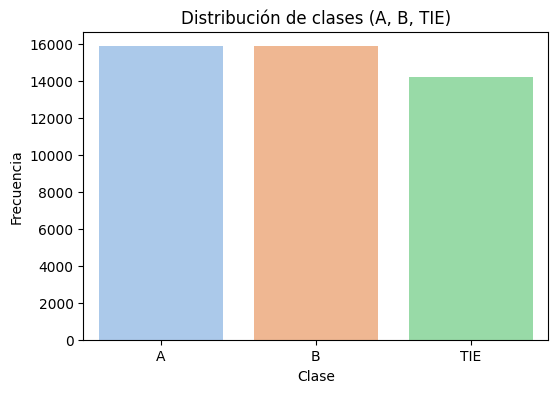

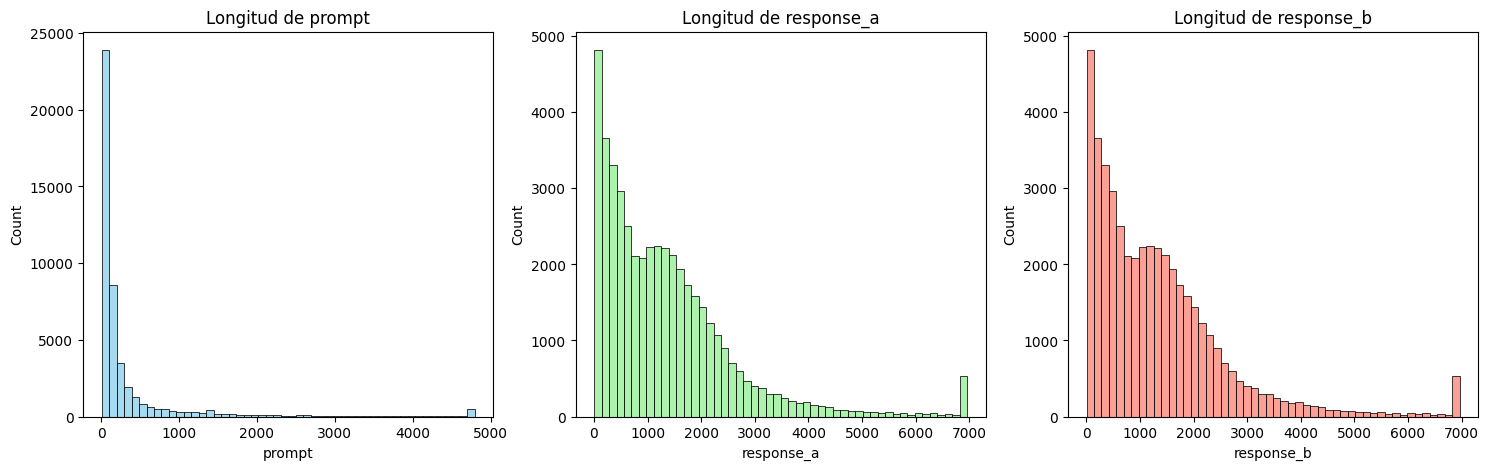

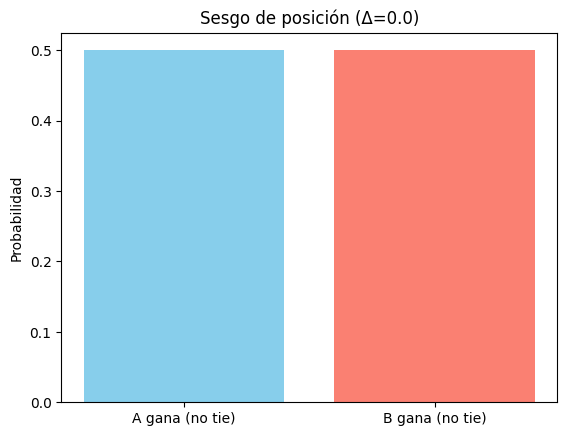

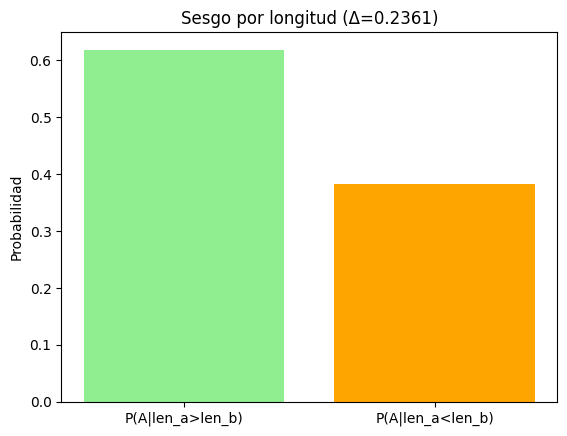

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Rutas de los archivos parquet ---
paths = {
    "train": Path("data/clean/train70_aug.parquet"),
    "val":   Path("data/clean/val15.parquet"),
    "test":  Path("data/clean/test15.parquet"),
}

df_train = pd.read_parquet(paths["train"]).copy()
df_val   = pd.read_parquet(paths["val"]).copy()
df_test  = pd.read_parquet(paths["test"]).copy()

df_train["split"] = "train"
df_val["split"]   = "val"
df_test["split"]  = "test"

def to_label(row) -> str:
    if row.get("winner_model_a", 0) == 1: 
        return "A"
    if row.get("winner_model_b", 0) == 1: 
        return "B"
    return "TIE"

for _df in (df_train, df_val, df_test):
    if "label" not in _df.columns:
        _df["label"] = _df.apply(to_label, axis=1)

df_train_trunc = df_train  

print("Shapes ->", df_train.shape, df_val.shape, df_test.shape)
print("Distribución de clases en train:\n", df_train_trunc["label"].value_counts())

# =====================================================
# Gráficas exploratorias
# =====================================================

# --- Distribución de clases ---
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_train_trunc, order=["A","B","TIE"], palette="pastel")
plt.title("Distribución de clases (A, B, TIE)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# --- Histogramas de longitud ---
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.histplot(df_train_trunc["prompt"].astype(str).str.len(), bins=50, ax=axes[0], color="skyblue")
axes[0].set_title("Longitud de prompt")
sns.histplot(df_train_trunc["response_a"].astype(str).str.len(), bins=50, ax=axes[1], color="lightgreen")
axes[1].set_title("Longitud de response_a")
sns.histplot(df_train_trunc["response_b"].astype(str).str.len(), bins=50, ax=axes[2], color="salmon")
axes[2].set_title("Longitud de response_b")
plt.show()

# --- Sesgo de posición ---
pA = (df_train_trunc.loc[df_train_trunc["label"]!="TIE","label"]=="A").mean()
pB = (df_train_trunc.loc[df_train_trunc["label"]!="TIE","label"]=="B").mean()
plt.bar(["A gana (no tie)", "B gana (no tie)"], [pA, pB], color=["skyblue","salmon"])
plt.title(f"Sesgo de posición (Δ={round(pA-pB,4)})")
plt.ylabel("Probabilidad")
plt.show()

# --- Sesgo por longitud ---
df_len = df_train_trunc.copy()
df_len["len_a"] = df_len["response_a"].astype(str).str.len()
df_len["len_b"] = df_len["response_b"].astype(str).str.len()
mask = (df_len["label"]!="TIE") & (df_len["response_a"]!=df_len["response_b"])

pA_gt = (df_len.loc[mask & (df_len["len_a"]>df_len["len_b"]),"label"]=="A").mean()
pA_lt = (df_len.loc[mask & (df_len["len_a"]<df_len["len_b"]),"label"]=="A").mean()

plt.bar(["P(A|len_a>len_b)", "P(A|len_a<len_b)"], [pA_gt, pA_lt], color=["lightgreen","orange"])
plt.title(f"Sesgo por longitud (Δ={round(pA_gt-pA_lt,4)})")
plt.ylabel("Probabilidad")
plt.show()

### Conclusiones

El análisis exploratorio permitió evaluar la calidad y estructura del dataset, destacando los siguientes puntos clave:

- **Etiquetas:** válidas y consistentes, con formato one-hot y distribución balanceada.  
- **Campos de texto:** completos, sin nulos ni vacíos en `prompt`, `response_a` o `response_b`.  
- **Duplicados:** se eliminaron 71 tripletas idénticas, evitando sobre-representación y riesgo de fuga de información.  
- **Inconsistencias:** se identificaron 27 casos con A==B pero sin etiqueta de empate; se aplicó una política de exclusión para mantener coherencia.  
- **Sesgos:** el sesgo de posición fue despreciable (Δ≈0.01), mientras que el sesgo por longitud resultó fuerte (Δ≈0.23). Se establecieron límites de truncado (p99) para mitigar su efecto.  
- **Dataset final:** después de limpieza, truncado y split sin fuga, se cuenta con un conjunto de datos robusto y listo para entrenamiento.

En conclusión, el dataset está en condiciones óptimas para entrenar modelos de clasificación multiclase. Las decisiones tomadas en esta etapa —deduplicación, control de inconsistencias y mitigación de sesgos— serán determinantes para mejorar la generalización y fiabilidad de los resultados en fases posteriores del proyecto.

# **Modelos**

## **Modelo 1 cross-encoder DeBERTa-v3-large**

In [13]:
import os, math, random
from dataclasses import dataclass
from typing import Dict, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel,
    Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
)

# Reproducibilidad
SEED = 42
set_seed(SEED)

# Etiquetas
LABEL2ID = {"A": 0, "B": 1, "TIE": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## **Utilidades y formateo del input**

In [14]:
def clean_text(s: Optional[str]) -> str:
    if s is None:
        return ""
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    # colapsa espacios sin romper saltos de línea
    s = " ".join(s.split())
    return s.strip()

def head_tail_truncate(text: str, max_chars: int, tail_frac: float = 0.25) -> str:
    if len(text) <= max_chars:
        return text
    head_len = int(math.ceil((1.0 - tail_frac) * max_chars))
    tail_len = max_chars - head_len
    return text[:head_len].rstrip() + "\n...\n" + text[-tail_len:].lstrip()

def build_input_text(prompt: str, a: str, b: str, sep: str = " [SEP] ") -> str:
    # Estructura legible y estable
    return f"[PROMPT]\n{prompt}{sep}[A]\n{a}{sep}[B]\n{b}"

def infer_label_from_onehot(r):
    if r.get("winner_model_a", 0) == 1: return "A"
    if r.get("winner_model_b", 0) == 1: return "B"
    return "TIE"


## **Carga de datos**

In [15]:
# Ajusta estas rutas a tus archivos
TRAIN_PATH = "data/clean/train70_aug.parquet"   # o train70.parquet si no usas augment
VAL_PATH   = "data/clean/val15.parquet"

df_train = pd.read_parquet(TRAIN_PATH)
df_val   = pd.read_parquet(VAL_PATH)

# Asegura columna label (A/B/TIE)
if "label" not in df_train.columns:
    df_train = df_train.copy()
    df_train["label"] = df_train.apply(infer_label_from_onehot, axis=1)

if "label" not in df_val.columns:
    df_val = df_val.copy()
    df_val["label"] = df_val.apply(infer_label_from_onehot, axis=1)

df_train[["label"]].value_counts(normalize=True).rename("train %"), df_val[["label"]].value_counts(normalize=True).rename("val %")


(label
 A        0.345175
 B        0.345175
 TIE      0.309649
 Name: train %, dtype: float64,
 label
 A        0.345595
 B        0.343445
 TIE      0.310960
 Name: val %, dtype: float64)

## **Cross encoder**

In [16]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer,
        max_length: int = 512,
        max_char_prompt: int = 2048,
        max_char_resp: int = 4096,
        do_swap_augment: bool = False,
        seed: int = 42,
    ):
        rng = random.Random(seed)
        records = []

        for _, r in df.iterrows():
            p = head_tail_truncate(clean_text(r["prompt"]), max_char_prompt)
            a = head_tail_truncate(clean_text(r["response_a"]), max_char_resp)
            b = head_tail_truncate(clean_text(r["response_b"]), max_char_resp)
            lab = r["label"]
            row = {"prompt": p, "response_a": a, "response_b": b, "label_id": LABEL2ID[lab]}
            records.append(row)

            # swap augmentation: A<->B y etiqueta A<->B (TIE se mantiene)
            if do_swap_augment:
                sr = dict(row)
                sr["response_a"], sr["response_b"] = row["response_b"], row["response_a"]
                if lab == "A":    sr["label_id"] = LABEL2ID["B"]
                elif lab == "B":  sr["label_id"] = LABEL2ID["A"]
                else:             sr["label_id"] = LABEL2ID["TIE"]
                records.append(sr)

        self.data = records
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, int]]:
        r = self.data[idx]
        text = build_input_text(r["prompt"], r["response_a"], r["response_b"])
        enc = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding=False,  # padding en collator
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(r["label_id"], dtype=torch.long)
        return item


## **Modelo**

In [17]:
class DebertaXEncForABTie(PreTrainedModel):
    """
    Logits: [A, B, TIE]
    Loss = CE(3-clases) + w * PairwiseMargin(A vs B) (solo para ejemplos no-TIE)
    """
    def __init__(self, config: AutoConfig, margin: float = 0.5, pairwise_loss_weight: float = 0.2):
        super().__init__(config)
        self.backbone = AutoModel.from_config(config)
        hidden = config.hidden_size
        self.dropout = nn.Dropout(getattr(config, "hidden_dropout_prob", 0.1))
        self.classifier = nn.Linear(hidden, 3)
        self.ce = nn.CrossEntropyLoss()
        self.margin = margin
        self.pairwise_loss_weight = pairwise_loss_weight
        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        out = self.backbone(
            input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        cls = out.last_hidden_state[:, 0, :]  # pooling [CLS]
        logits = self.classifier(self.dropout(cls))

        if labels is None:
            return {"logits": logits}

        # CE principal
        ce_loss = self.ce(logits, labels)

        # Pairwise margin auxiliar (sólo A/B)
        a = logits[:, 0]
        b = logits[:, 1]
        y = torch.zeros_like(labels, dtype=torch.float)
        y[labels == LABEL2ID["A"]]  =  1.0
        y[labels == LABEL2ID["B"]]  = -1.0
        mask = (labels != LABEL2ID["TIE"]).float()
        pairwise = torch.clamp(self.margin - y * (a - b), min=0.0)
        pairwise = (pairwise * mask).sum() / torch.clamp(mask.sum(), min=1.0)

        loss = ce_loss + self.pairwise_loss_weight * pairwise
        return {"loss": loss, "logits": logits, "ce_loss": ce_loss, "pairwise_loss": pairwise}


## **Entrenamiento**

In [19]:
!pip -q install --upgrade pip setuptools wheel
!pip -q install -U "transformers>=4.42.0" "accelerate>=0.30.0" datasets pyarrow scikit-learn
!pip -q install -U "sentencepiece>=0.1.99" "protobuf==4.25.3" "tokenizers>=0.15.0"

MODEL_NAME = "microsoft/deberta-v3-large"
OUTPUT_DIR = "outputs/deberta_xenc"  # carpeta de checkpoints

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
cfg = AutoConfig.from_pretrained(MODEL_NAME)

# Construimos nuestro modelo con la cabeza custom
model = DebertaXEncForABTie(cfg, margin=0.5, pairwise_loss_weight=0.2)

# Cargamos los pesos del backbone preentrenado
base = AutoModel.from_pretrained(MODEL_NAME, config=cfg)
model.backbone.load_state_dict(base.state_dict(), strict=False)
del base
model.to(device)

# Hiperparámetros clave
MAX_LEN = 512
MAX_CHAR_PROMPT = 2048
MAX_CHAR_RESP   = 4096
USE_SWAP_AUG    = False  # ya tienes train70_aug; si fuese train70, puedes poner True

train_ds = TripletDataset(
    df_train, tok, max_length=MAX_LEN,
    max_char_prompt=MAX_CHAR_PROMPT, max_char_resp=MAX_CHAR_RESP,
    do_swap_augment=USE_SWAP_AUG, seed=SEED
)
val_ds = TripletDataset(
    df_val, tok, max_length=MAX_LEN,
    max_char_prompt=MAX_CHAR_PROMPT, max_char_resp=MAX_CHAR_RESP,
    do_swap_augment=False, seed=SEED
)

len(train_ds), len(val_ds)


  You can safely remove it manually.
c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[h

(45910, 17208)

## **Métricas y trainer**

In [ ]:
!pip -q uninstall -y transformers tokenizers
!pip -q install -U "transformers==4.44.2" "accelerate>=0.30.0" sentencepiece "protobuf==4.25.3"

import transformers, sys, torch
from inspect import signature
print("transformers:", transformers.__version__)
print("python:", sys.version)
print("torch:", torch.__version__)
print("transformers file:", transformers.__file__)
print("has evaluation_strategy:", "evaluation_strategy" in signature(transformers.TrainingArguments.__init__).parameters)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    f1w = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

collator = DataCollatorWithPadding(tok)

from transformers import AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from inspect import signature

# 3.1 — SIEMPRE usar tokenizer lento (evita 'tokenizers' y Rust)
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

# 3.2 — Helper: crea TrainingArguments compatible con cualquier versión
def make_training_args(**kwargs):
    # Filtra kwargs no soportados por tu versión instalada
    sig = signature(TrainingArguments.__init__)
    allowed = {k: v for k, v in kwargs.items() if k in sig.parameters}
    # Ajustes por si faltan claves modernas
    if "evaluation_strategy" not in sig.parameters and "evaluation_strategy" in kwargs:
        # versión antigua → ignoramos y luego evaluamos al final manualmente
        allowed.pop("evaluation_strategy", None)
        allowed.pop("save_strategy", None)
        allowed.pop("load_best_model_at_end", None)
        allowed.pop("metric_for_best_model", None)
        allowed.pop("greater_is_better", None)
        allowed.pop("report_to", None)
    return TrainingArguments(**allowed)

collator = DataCollatorWithPadding(tok)

targs = make_training_args(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.06,
    evaluation_strategy="steps",   # se filtra si tu versión no lo soporta
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    save_strategy="steps",         # idem
    logging_steps=50,
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    fp16=torch.cuda.is_available(),
    bf16=False,
    report_to=["none"],
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
)

class XEncTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)
        loss = outputs["loss"]
        return (loss, outputs) if return_outputs else loss

trainer = XEncTrainer(
    model=model,
    args=targs,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tok,   # ← en vez de tokenizer=tok
    data_collator=collator,
    compute_metrics=compute_metrics,
)


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      Checking for Rust toolchain....
      Rust not found, installing into a temporary directory
      Python reports SOABI: cp313-win_amd64
      Computed rustc target triple: x86_64-pc-windows-msvc
      Installation directory: C:\Users\garci\AppData\Local\puccinialin\puccinialin\Cache
      Rustup already downloaded
      Installing rust to C:\Users\garci\AppData\Local\puccinialin\puccinialin\Cache\rustup
      warn: It looks like you have an existing rustup settings file at:
      warn: C:\Users\garci\.rustup\settings.toml
      warn: Rustup will install the default toolchain as specified in the settings file,
      warn: instead of the one inferred from the default host triple.
      info: profile set to 'minimal'
      info: default host triple is x86_64-pc-windows-msvc
      warn: Updating existing toolchain, profile choice will 

transformers: 4.57.1
python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
torch: 2.7.1+cpu
transformers file: c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\__init__.py
has evaluation_strategy: False


C:\Users\garci\AppData\Local\Temp\ipykernel_10868\903310528.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `XEncTrainer.__init__`. Use `processing_class` instead.
  trainer = XEncTrainer(


## **Entrenamiento**

In [24]:
train_result = trainer.train()
trainer.save_model(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)

metrics = trainer.evaluate()
metrics


TypeError: XEncTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'